# Scikit Learn

Cheat Sheet to help with choosing the appropriate algorithm

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Overview of clustering methods!!!!

https://scikit-learn.org/stable/modules/clustering.html

List of modules to import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_decision_regions

# from sklearn import set_config; set_config(display='diagram')
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer




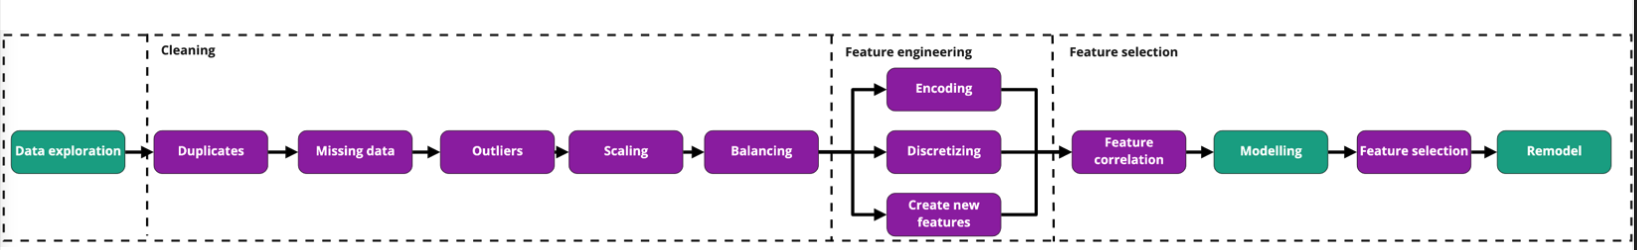

### 0.1 Memory Optimization

For large dataset, it may be useful to compress data by "downcasting" dtypes to the smallest possible values according to existing ranges in your dataset

In [35]:
s_int = pd.Series([1, 2, 334])
s_int

0      1
1      2
2    334
dtype: int64

pd.Series.astype allows to specify a particular numpy data type

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.astype.html

https://numpy.org/devdocs/user/basics.types.html

In [36]:
s_int = s_int.astype(np.int16)
s_int

0      1
1      2
2    334
dtype: int16

You need to be very cautious when doing this, as downcasting too far can alter the data 

👇 Beware of the haircut!

In [37]:
s_int = s_int.astype(np.int8)
s_int

0     1
1     2
2    78
dtype: int8

In [40]:
print(2**8)
print(334 - 2**8)

256
78


In [43]:
a = np.array([0.1234567890123456789, 2, 3], dtype=np.float16)
print("16bit: ", a[0])

b = np.array([0.1234567890123456789, 2, 3], dtype=np.float32)
print("32bit: ", b[0])

c = np.array([0.1234567890123456789, 2, 3], dtype=np.float64)
print("64bit: ", c[0])

16bit:  0.1235
32bit:  0.12345679
64bit:  0.12345678901234568


👉 Be careful when playing with float precision, especially when scaling

☝️ float32 should be enough for most of your first Data Science projects

☝️ float16 is extremely uncommon

Downcast made easy with pd.to_numeric 😍

    Converts to the smallest possible int data type that do not change values
    
    Also turns floats64 to floats32
    
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html

In [44]:
s_float = pd.Series([0.1234567890123456789, 2, 3], dtype=np.float64)
s_int = pd.Series([1, 2, 334])

print(pd.to_numeric(s_int, downcast='integer'), '\n')
print(pd.to_numeric(s_float, downcast='float'))

0      1
1      2
2    334
dtype: int16 

0    0.123457
1    2.000000
2    3.000000
dtype: float32


In [46]:
df = pd.DataFrame(dict(
    my_int=[123 for _ in range(100)], # int64
    my_float=[1.0 for _ in range(100)], # float64
    my_bool=[True for _ in range(100)])) # bool

df

my_int  my_float  my_bool
0      123       1.0     True
1      123       1.0     True
2      123       1.0     True
3      123       1.0     True
4      123       1.0     True
..     ...       ...      ...
95     123       1.0     True
96     123       1.0     True
97     123       1.0     True
98     123       1.0     True
99     123       1.0     True

[100 rows x 3 columns]

In [48]:
df.memory_usage()

Index       128
my_int      800
my_float    800
my_bool     100
dtype: int64

#### 0.1.1 Code For DataFrame Compression

In [49]:
def compress(df, **kwargs):
    """
    Reduces size of dataframe by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024
    print("new dataframe size: ", round(input_size,2), 'kB')
    
    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100
    
    print("optimized size by {} %".format(round(ratio,2)))
    print("new dataframe size: ", round(out_size / 1024,2), " kB")
    
    return df

In [50]:
compress(df)
df.memory_usage()

new dataframe size:  1.79 kB
optimized size by 60.0 %
new dataframe size:  0.71  kB


Index       128
my_int      100
my_float    400
my_bool     100
dtype: int64

In [51]:
df.dtypes

my_int         int8
my_float    float32
my_bool        bool
dtype: object

#### 0.1.2 Compress While Loading Data Into Pandas

We can force optimal dtype directly at loading to minimize RAM

In [53]:
DATA_URL = "data/train_100k.csv"

In [56]:
DATA_URL = "~/.lewagon/mlops/data/raw/train_100k.csv"
df = pd.read_csv(DATA_URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  99999 non-null   float64
 6   dropoff_latitude   99999 non-null   float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


In [54]:
DTYPES_RAW_OPTIMIZED = {
    "key": "O",
    "fare_amount": "float32",
    "pickup_datetime": "O",
    "pickup_longitude": "float32",
    "pickup_latitude": "float32",
    "dropoff_longitude": "float32",
    "dropoff_latitude": "float32",
    "passenger_count": "int8"
}

df = pd.read_csv(DATA_URL, dtype=DTYPES_RAW_OPTIMIZED)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float32
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float32
 4   pickup_latitude    100000 non-null  float32
 5   dropoff_longitude  99999 non-null   float32
 6   dropoff_latitude   99999 non-null   float32
 7   passenger_count    100000 non-null  int8   
dtypes: float32(5), int8(1), object(2)
memory usage: 3.5+ MB


## 1. Data Cleaning

In [3]:
data_c = pd.read_csv('data/ML_Cars_dataset.csv')
data_c.head()

aspiration enginelocation carwidth  curbweight enginetype cylindernumber  \
0        std          front     64.1        2548       dohc           four   
1        std          front     64.1        2548       dohc           four   
2        std          front     65.5        2823       ohcv            six   
3        std          front      NaN        2337        ohc           four   
4        std          front     66.4        2824        ohc           five   

   stroke  peakrpm      price  
0    2.68     5000  expensive  
1    2.68     5000  expensive  
2    3.47     5000  expensive  
3    3.40     5500  expensive  
4    3.40     5500  expensive

Typically in this order:

    1. Duplicates
    2. Missing Data
    3. Outliers
    4. Scaling
    5. Balancing

### 1.0 Inspect The Data

In [67]:
data_c.describe()    #Gets count, mean, max, min, etc. for the dataset

curbweight      stroke      peakrpm
count   205.000000  205.000000   205.000000
mean   2555.565854    3.255415  5125.121951
std     520.680204    0.313597   476.985643
min    1488.000000    2.070000  4150.000000
25%    2145.000000    3.110000  4800.000000
50%    2414.000000    3.290000  5200.000000
75%    2935.000000    3.410000  5500.000000
max    4066.000000    4.170000  6600.000000

Check the data type of the features. Note that some of them may be formated incorrectly, such as the carwidth below.

In [68]:
data_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   aspiration      205 non-null    object 
 1   enginelocation  195 non-null    object 
 2   carwidth        203 non-null    object 
 3   curbweight      205 non-null    int64  
 4   enginetype      205 non-null    object 
 5   cylindernumber  205 non-null    object 
 6   stroke          205 non-null    float64
 7   peakrpm         205 non-null    int64  
 8   price           205 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 14.5+ KB


See how many NaN values there are in the data features

In [59]:
data_c.isnull().sum().sort_values(ascending=False).head(15)

enginelocation    10
carwidth           2
aspiration         0
curbweight         0
enginetype         0
cylindernumber     0
stroke             0
peakrpm            0
price              0
dtype: int64

See the count of features with a certain data type

In [60]:
data_c.dtypes.value_counts()

object     6
int64      2
float64    1
dtype: int64

Split features into different data types.   

Makes sense if there are a large number of features, or if you are going for engineer different feature types differently, for instance scaling numerical features, and encoding catagorical ones. 

In [64]:
X_cat = data_c.drop('price', axis = 1).select_dtypes(exclude=[int,float]).copy()
X_num = data_c.drop('price', axis = 1).select_dtypes(include=[int, float]).copy()

X_cat

aspiration enginelocation carwidth enginetype cylindernumber
0          std          front     64.1       dohc           four
1          std          front     64.1       dohc           four
2          std          front     65.5       ohcv            six
3          std          front      NaN        ohc           four
4          std          front     66.4        ohc           five
..         ...            ...      ...        ...            ...
200        std          front     68.9        ohc           four
201      turbo          front     68.8        ohc           four
202        std          front     68.9       ohcv            six
203      turbo          front     68.9        ohc            six
204      turbo          front     68.9        ohc           four

[205 rows x 5 columns]

See how many unique values each of the features has.

In [65]:
feat_categorical_nunique_cat = pd.DataFrame(columns = ['Feature', 'Unique_Values'])

for column in X_cat.columns:   
    feat_categorical_nunique_cat.loc[len(feat_categorical_nunique_cat.index)] = [column, X_cat[column].nunique()]
    
feat_categorical_nunique_cat.sort_values('Unique_Values', ascending=False)

Feature Unique_Values
2        carwidth            43
3      enginetype             7
4  cylindernumber             7
0      aspiration             2
1  enginelocation             2

### 1.1 Duplicates

In [76]:
duplicate_count = data_c.duplicated().sum()
print(f'Duplicates: {duplicate_count}')
print(f'Total Data: {len(data_c)}')
print(f'Anticipated Data After Drop: {len(data_c)-duplicate_count}')
data_c.drop_duplicates(inplace = True)
print(f'Confirm Data After Drop: {len(data_c)}')

Duplicates: 14
Total Data: 205
Anticipated Data After Drop: 191
Confirm Data After Drop: 191


### 1.2 Missing Data

#### 1.2.1 Finding Missing Data

First look to see how may NaN's there are in the DataFrame. You should also read any documentation on the data to see if NaN is in fact data. 

Also, NaN is not the only form that missing data can take. You should also check the unique values (to find non-NaN errors) in a series and the max and the max and min to see if there are any non-sensical outliers. 

In [82]:
data_c.isnull().sum().sort_values(ascending=False) #NaN count for each column

data_c.isnull().sum().sort_values(ascending=False)/len(data_c) #NaN percentage for each column

enginelocation    0.052356
carwidth          0.010471
aspiration        0.000000
curbweight        0.000000
enginetype        0.000000
cylindernumber    0.000000
stroke            0.000000
peakrpm           0.000000
price             0.000000
dtype: float64

In [83]:
data_c.carwidth.unique()

array(['64.1', '65.5', nan, '66.4', '66.3', '71.4', '67.9', '64.8',
       '66.9', '70.9', '60.3', '*', '63.6', '63.8', '64.6', '63.9', '64',
       '65.2', '66', '61.8', '69.6', '70.6', '64.2', '65.7', '66.5',
       '66.1', '70.3', '71.7', '70.5', '72', '68', '64.4', '65.4', '68.4',
       '68.3', '65', '72.3', '66.6', '63.4', '65.6', '67.7', '67.2',
       '68.9', '68.8'], dtype=object)

#### 1.2.2 Handling Missing Data

What can you do with missing data?

    1. Drop the column
    2. Replace the data manually (for instance, when NaN means something)
    3. Use SimpleImputer to replace the missing data

You will have you use your judgement on how to choose what to do. Things to consider are:

    - Impute with most frequent
    - Impute with median
    - Drop the entire column

##### 1.2.2.1 Drop The Column

In [84]:
# data_c.drop(columns='WallMat', inplace=True) #Drop single column
# data_c.drop(columns = ['column_1', 'column_2'], axis = 1, inplace = True)

##### 1.2.2.2 Drop The Row

In [16]:
nums = {'Integers_1': [10, 15, 30, 40, 55, np.nan,
                       75, np.nan, 90, 150, np.nan],
        'Integers_2': [np.nan, 21, 22, 23, np.nan,
                       np.nan, 25, np.nan, 26, np.nan,
                       np.nan],
        'Integers_3': [21, np.nan, 22, np.nan, 23,
                       np.nan, np.nan, 25, 26, np.nan,
                       np.nan],
       }

df = pd.DataFrame(nums)

display(df)

# Drop Rows with Any NaN Values

print('\nDrop Rows with ANY NaN Values\n')
display(df.dropna())

# Drop Rows with ALL NaN Values 

print('\nDrop Rows with ALL NaN Values\n')
display(df.dropna(how = 'all'))

# Drop Rows Below a Certain Threshold
# Keeps the rows with number of NaN's below the threshhold

print('\nDrop Rows Above a Certain Threshold\n')
display(df.dropna(thresh=2))

# Drop Row with Nan Values in Specific Columns

print('\nDrop Row with Nan Values in Specific Columns\n')
display(df.dropna(subset = ['Integers_1','Integers_2']))

Integers_1  Integers_2  Integers_3
0         10.0         NaN        21.0
1         15.0        21.0         NaN
2         30.0        22.0        22.0
3         40.0        23.0         NaN
4         55.0         NaN        23.0
5          NaN         NaN         NaN
6         75.0        25.0         NaN
7          NaN         NaN        25.0
8         90.0        26.0        26.0
9        150.0         NaN         NaN
10         NaN         NaN         NaN


Drop Rows with ANY NaN Values



Integers_1  Integers_2  Integers_3
2        30.0        22.0        22.0
8        90.0        26.0        26.0


Drop Rows with ALL NaN Values



Integers_1  Integers_2  Integers_3
0        10.0         NaN        21.0
1        15.0        21.0         NaN
2        30.0        22.0        22.0
3        40.0        23.0         NaN
4        55.0         NaN        23.0
6        75.0        25.0         NaN
7         NaN         NaN        25.0
8        90.0        26.0        26.0
9       150.0         NaN         NaN


Drop Rows Above a Certain Threshold



Integers_1  Integers_2  Integers_3
0        10.0         NaN        21.0
1        15.0        21.0         NaN
2        30.0        22.0        22.0
3        40.0        23.0         NaN
4        55.0         NaN        23.0
6        75.0        25.0         NaN
8        90.0        26.0        26.0


Drop Row with Nan Values in Specific Columns



Integers_1  Integers_2  Integers_3
1        15.0        21.0         NaN
2        30.0        22.0        22.0
3        40.0        23.0         NaN
6        75.0        25.0         NaN
8        90.0        26.0        26.0

##### 1.2.2.2 Replace Manually

In [94]:
data_c.enginelocation.replace(np.nan, "front", inplace=True) #Replace the NaN values in engine location with "front", as this is the most common (by far)

Note that the NaN value is a NumPy feature, so you'll need to import NumPy to work with it.

In [87]:
data_c.isnull().sum().sort_values(ascending=False)

carwidth          2
aspiration        0
enginelocation    0
curbweight        0
enginetype        0
cylindernumber    0
stroke            0
peakrpm           0
price             0
dtype: int64

In [91]:
data_c.carwidth.replace('*', np.nan, inplace=True)

##### 1.2.2.3 Simple Imputer (sklearn.impute.SimpleImputer)

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simple%20imputer#sklearn.impute.SimpleImputer

SimpleImputer is a tool to replace missing values by a strategy of your choice e.g. mean.

In [93]:
imputer = SimpleImputer(strategy="median") # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(data_c[['carwidth']]) # Call the "fit" method on the object

data_c['carwidth'] = imputer.transform(data_c[['carwidth']]) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

array([65.5])

##### 1.2.2.4 KNNImputer (sklearn.impute.KNNImputer)

In [138]:
from sklearn.impute import KNNImputer

KNNImputer(n_neighbors=5)

KNNImputer()

### 1.3 Outliers

#### 1.3.1 Finding Outliers

You would typically us a boxplot or histogram to look for outliers.

<AxesSubplot:>

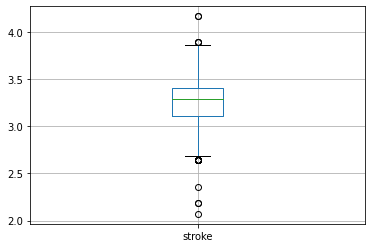

In [96]:
data_c[['stroke']].boxplot()

array([[<AxesSubplot:title={'center':'stroke'}>]], dtype=object)

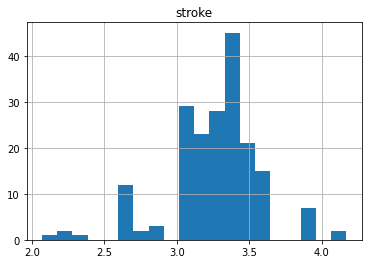

In [98]:
data_c[['stroke']].hist(bins = 20)

#### 1.3.2 Dealing With Outliers

🚨Outliers can be an opinion. We must fully comprehend what an outlier is before removing it from the dataset.

In [ ]:
false_observation = data['GrLivArea'].argmin() # Get index corresponding to minimum value

data = data.drop(false_observation).reset_index(drop=True) # Drop row, reset_index

### 1.4 Scaling

ℹ️ Transforming continuous features into a common, smaller range.

🚨Remember, not all numerical columns are continuous, always think about what the data represents in real life.

Why scaling?

    Features with large magnitudes can incorrectly outweigh features of small magnitudes
    Scaling to smaller magnitudes improves computational efficiency
    Increases interpretability of feature coefficients
    
There are three ways to scale the data:

    Standard Scaling (z-score adjust): Normal Dist., doesn't handle outliers well
    Robust Scaling: Normal Dist, handles outliers better
    Max/Min Scaling (Normalizing): Good for everything else

#### 1.4.1 Standard Scaler (sklearn.preprocessing.StandardScaler)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Transforms a feature so that it has a mean value of 0 and a standard deviation of 1.

    Most efficient when data is normally distributed
    Does not ensure an exact common range
    Sensitive to outliers
    Can distort relative distances between feature values

In [213]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Instanciate StandarScaler

scaler.fit(data_c[['curbweight']]) # Fit scaler to data

data_c['curbweight'] = scaler.transform(data_c[['curbweight']]) # Use scaler to transform data

#### 1.4.2 Robust Scaler (sklearn.preprocessing.RobustScaler)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

Robust Scaling uses central tendency metrics that are less sensitive to outliers.

In [214]:
r_scaler = RobustScaler() # Instanciate Robust Scaler

r_scaler.fit(data_c[['peakrpm']]) # Fit scaler to feature

data_c['peakrpm'] = r_scaler.transform(data_c[['peakrpm']]) #Scale

#### 1.4.3 Min Max Scaling (sklearn.preprocessing.MinMaxScaler)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

Good for non-normal distributed features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms_scaler = MinMaxScaler() # Instanciate MinMaxScaler

mms_scaler.fit(data_c[['carwidth']]) # Fit scaler to data

data_c['carwidth'] = mms_scaler.transform(data_c[['carwidth']]) #Scale

### 1.6 Balancing


Haven't done this yet

## 2. Feature Engineering

### 2.1 Encoding

Encoding consists of transforming non-numerical data to an equivalent numerical form.

Why encoding?

    Data may be represented as words, letters, or symbols
    Most Machine Learning algorithms only process numerical data
    
**Target Encoding** - Assign a number to each category.

**Feature Encoding** - Create a binary column for each possible category. This is also known as One Hot Encoding.

LabelEncoder

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

#### 2.1.1 One-Hot-Encoding (sklearn.preprocessing.OneHotEncoder)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

This can be generally done in two ways:

    - Binary: if you set the 'drop = "if_binary"' argument, it will map a feature to either 1 or 0 in the same column. 
    - Non-Binary: for a feature with more than two unique values, you would ommit this, and this would split the column 
                  into as many columns as there are unique values.

##### 2.1.1.1 - Binary Example

In [112]:
ohe = OneHotEncoder(drop='if_binary', sparse = False) # Instantiate encoder for binary feature

ohe.fit(data_c[['aspiration']]) # Fit encoder

data_c['aspiration'] = ohe.transform(data_c[['aspiration']]) # Encode Street

You can see the values that OHE converted to [0,1] by calling the 'categories_' feature

In [113]:
ohe.categories_

[array(['std', 'turbo'], dtype=object)]

##### 2.1.1.1 - Non- Binary Example

For a non-binary feature you will also have to specify the labels for the columns that OHE maps the information to. 

**OHE MAPS THE VALUES OF THE FEATURES TO THE COLUMNS ALPHABETICALLY** 
**MAKE SURE YOU CHECK THIS BY CALLING THE 'CATEGORIES_' FEATURE!!!**

In [115]:
ohe = OneHotEncoder(sparse = False) # Instantiate encoder for binary feature

ohe.fit(data_c[['enginetype']]) # Fit encoder

et_encoded = ohe.transform(data_c[['enginetype']]) # Transform the data

data_c["dohc"],data_c["dohcv"],data_c['l'],data_c["ohc"],data_c["ohcf"],data_c["ohcv"],data_c["rotor"] = et_encoded.T #Map the array to the new columns

In [116]:
ohe.categories_

[array(['dohc', 'dohcv', 'l', 'ohc', 'ohcf', 'ohcv', 'rotor'], dtype=object)]

If there are NaN's in the data, you will have to set "handle_unknowns = 'ignore'" to avoid an error. Also, setting sparse to False will stop it from outputting a sparse matrix, which can be hard to interpret (and will look weird if you try to inspect it). 

In [ ]:
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

#### 2.1.2 Label Encoder (sklearn.preprocessing.LabelEncoder)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Encode target labels with value between 0 and n_classes-1.

This transformer should be used to encode target values, i.e. y, and not the input X.

In [118]:
le = LabelEncoder()

le.fit(data_c['price']) # Fit encoder

data_c['price'] = le.transform(data_c['price']) # Encode Street

In [123]:
list(le.classes_)

[0, 1]

#### 2.1.3 Manual Encoding

This can be done using the map() method (pandas.Series.map).

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html

In [139]:
data_c['cylindernumber'] = data_c.cylindernumber.map(
            {'four': 4,
             'six': 6,
             'five': 5,
             'three': 3,
             'twelve': 12,
             'two':2,
             'eight':8})
             

Or with a lambda function. The one below uses the values of multiple features to generata a new feature called 'Volume'

In [ ]:
data = data.assign(Volume = lambda x: x["product_length_cm"] * x["product_height_cm"] * x["product_width_cm"])

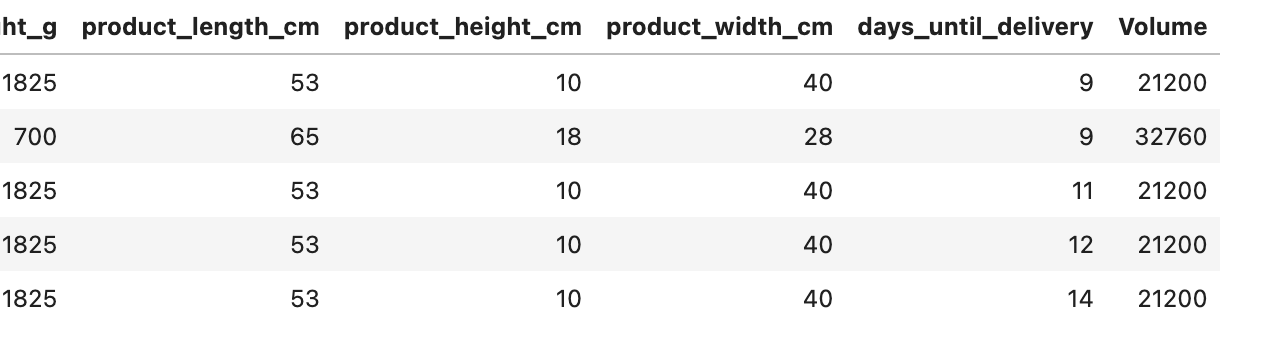

This can also be done in a FunctionTransformer component of a pipeline

In [ ]:
volume_constructor = FunctionTransformer(lambda df: pd.DataFrame(df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]))

#### 2.1.4 Encoding Cyclical Features

This can include:
    
    - Time
    - Dates
    - Months

Read the article below on how this can be done with a sin and cos function.
   
https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

In [ ]:
import math

def transform_time_features(X: pd.DataFrame)->np.ndarray:
    assert isinstance(X, pd.DataFrame)
    pickup_dt = pd.to_datetime(X["pickup_datetime"],
                                format="%Y-%m-%d %H:%M:%S UTC",
                                utc=True)
    pickup_dt = pickup_dt.dt.tz_convert("America/New_York").dt
    dow = pickup_dt.weekday
    hour = pickup_dt.hour
    month = pickup_dt.month
    year = pickup_dt.year
    hour_sin = np.sin(2 * math.pi / 24 * hour)
    hour_cos = np.cos(2*math.pi / 24 * hour)
    
    return np.stack([hour_sin, hour_cos, dow, month, year], axis=1)

X_time_processed = transform_time_features(X[["pickup_datetime"]])

pd.DataFrame(X_time_processed, columns=["hour_sin", "hour_cos", "dow", "month", "year"]).head()

#### 2.1.5 Ordinal Encoder (sklearn.preprocessing.OrdinalEncoder)

Encode categorical features as an integer array.

The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are converted to ordinal integers. This results in a single column of integers (0 to n_categories - 1) per feature.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

The example below is from the Houses Kaggle Competition challenge from the ensembles module (LeWagon Bootcamp). Basically, you specify the ranking of a features categorical values, and the encoder assigns them a numerical value in a single column. 

This is only to be used for features with related, sequencial values (for example, 'bd' = bad, 'ok' = Ok and 'gd' = good, could be converted to [0,1,2].

In [ ]:
X_train[['GarageQual','BsmtFinType1','GarageFinish']]

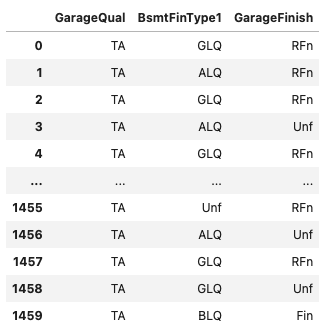

In [ ]:
# Define specific order for features
# Note: if you change this order, it will change the output for .transform()

# You need to have on feature array for each feature you want to pass to the encoder.

feature_A_sorted_values = ['None','Po','Fa','TA', 'Gd', 'Ex'] 
feature_B_sorted_values = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
feature_C_sorted_values = ['None', 'Unf', 'RFn', 'Fin']

# If you don't pass the lists above when creating the instance, the encoder will somehow try to figure out the order itself. 

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values,
        feature_C_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Note that even though you have definted the order above of the features values, you are still required to fit the encoder. 

encoder.fit(X_train[['GarageQual','BsmtFinType1','GarageFinish']])

# Aaaand transfor the features

encoded = encoder.transform(X_train[['GarageQual','BsmtFinType1','GarageFinish']])

# Aaaaaaaand convert the output array to a df

encoded = pd.DataFrame(encoded, columns = X_train[['GarageQual','BsmtFinType1','GarageFinish']].columns)


### 2.2 Discretizing

Discretizing is the process of turning continuous data into discrete data using bins.

    Turn a regression task into a classification task
    Perform feature engineering

#### 2.2.1 Pandas Cut

pandas.cut

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

In [ ]:
data['SalePriceBinary'] = pd.cut(x = data['SalePrice'],
                       bins=[data['SalePrice'].min()-1,
                             data['SalePrice'].mean(),
                             data['SalePrice'].max()+1], 
                       labels=['cheap', 'expensive'])


### 2.3 Create New Features

In [ ]:
data = data.assign(Volume = lambda x: x["product_length_cm"] * x["product_height_cm"] * x["product_width_cm"])


## 3. Feature Selection

Includes:

    - Feature Correlation
    - Modelling
    - Feature Selection
    - Remodel

### 3.1 Feature Correlation

A first selection technique is to remove one of two features that are highly correlated to each other.

    High correlation = redundant information

This is done to reduce the computational requirements by eliminating less usefull information.

**NOTE THAT THIS IT FEATURE CORRELATION, NOT THEIR CORRELATION WITH THE TARGET!!**

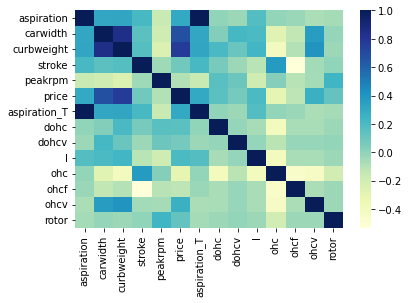

In [128]:
# Heatmap
corr = data_c.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu");

In [130]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df

feature_1     feature_2  correlation
84   aspiration_T    aspiration     1.000000
6      aspiration  aspiration_T     1.000000
29     curbweight      carwidth     0.847498
16       carwidth    curbweight     0.847498
33     curbweight         price     0.767866
..            ...           ...          ...
152           ohc          ohcv    -0.436077
151           ohc          ohcf    -0.453815
164          ohcf           ohc    -0.453815
53         stroke          ohcf    -0.534229
157          ohcf        stroke    -0.534229

[182 rows x 3 columns]

In [131]:
corr_df.query('feature_1 == "price"')

feature_1     feature_2  correlation
72     price    curbweight     0.767866
71     price      carwidth     0.679997
70     price    aspiration     0.303864
76     price  aspiration_T     0.303864
82     price          ohcv     0.266036
79     price             l     0.198402
77     price          dohc     0.153449
83     price         rotor     0.124354
73     price        stroke     0.085292
78     price         dohcv     0.071417
74     price       peakrpm    -0.093893
81     price          ohcf    -0.124964
80     price           ohc    -0.306012

Our suggestion: remove as many feature as you want, starting from those with the highest correlation, until your model performance starts to drop too significantly

### 3.2 Modelling (Done Using The Algorithms Detailed Below)

- Linear Regression (sklearn.linear_model.LinearRegression)
- Logistic Regression (sklearn.linear_model.LogisticRegression)

### 3.3 Feature Selection (Permutation)

Feature permutation is a second feature selection algorithm that evaluates the importance of each feature in predicting the target.

    Trains and records the test score of a base model containing all features
    Randomly shuffles (permutation) a feature within the test set
    Records new score on shuffled test set
    Compares the new score to the original score
    Repeat for each feature

👉 If the score drops when a feature is shuffled, it is considered important.


#### 3.3.1 Permutation Importance (sklearn.inspection.permutation_importance)

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

This shows you the effect that dropping a feature would have on the cross-validation score of the model. Great way to trim down unimportant features. 

In [141]:
from sklearn.inspection import permutation_importance

X = data_c[['curbweight', 'aspiration', 'dohc', 'l', 'ohc', 'ohcf', 'ohcv', 'rotor', 'cylindernumber']].copy()
y = data_c['price'].copy()

log_model = LogisticRegression().fit(X, y) # Fit model

permutation_score = permutation_importance(log_model, X, y, n_repeats=10) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X.columns, permutation_score.importances_mean)).T) # Unstack results

importance_df.columns=['feature','score decrease']

importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

feature score decrease
0      curbweight       0.379058
4             ohc       0.013089
7           rotor       0.013089
1      aspiration       0.006806
8  cylindernumber       0.005759
5            ohcf       0.004188
2            dohc            0.0
3               l            0.0
6            ohcv            0.0

## 4 Performance Metrics

### 4.1 Baseline Score

When evaluating a machine learning pipeline, you need a basis for comparison. A baseline score utilizes very simple strategies for prediction:

    Classification: Predicts a random or most frequent class
    Regression: Predicts a central tendency measure e.g. mean, median or mode

Alternately, you can just do a regression on the data as you get it, before any cleaning, scaling, feture selection, etc. 

From there any work done on the model should improve the score of the prediction. 

### 4.2 Regression Metrics

Metrics used in scoring how well a predictive model works always do so my comparing the predictions of the model with the observed 'ground truth', or target.

There are LOTS of ways this can be done, with some being more appropriate depending on the context and use of the predictor.

👉 Use MSE when you need to penalize large errors.

👉 Use RMSE when you want to penalize large errors, but see it in the unit of the target.

👉 Use MAE when all errors, large or small, have equal importance.

👉 Use Max Error when you want to limit the magnitude of the errors.

👉 Use R2 as a general metric to compare performance across different datasets.

A list of all the metrics and scoring available to SciKit Learn models is below:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

#### 4.2.1 Via Sklearn Metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import math

mse = mean_squared_error(y, y_pred)

rmse = math.sqrt(mse)

mae = mean_absolute_error(y, y_pred)

rsquared = r2_score(y, y_pred)

max_error = max_error(y, y_pred)

print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))
print('Max Error =', round(max_error, 2))

#### 4.2.2 Cross Validate Method

In [ ]:
from sklearn.model_selection import cross_validate
# 5-Fold Cross validate model
model = LinearRegression()
cv_results = cross_validate(model, X, y, cv=5, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error']
                           )
pd.DataFrame(cv_results) # Cross validation output

### 4.3 Classification Metrics

Two ways for a model to have a correct prediction:

    True Positive- Correctly identifying a positive sample
    True Negative- Correctly identifying a negative sample

Two ways a model can have an incorrect prediction:

    False Positive- Incorrectly identifying a positive sample
    False Negative- Incorrectly identifying a negative sample

**Confusion Matrix**

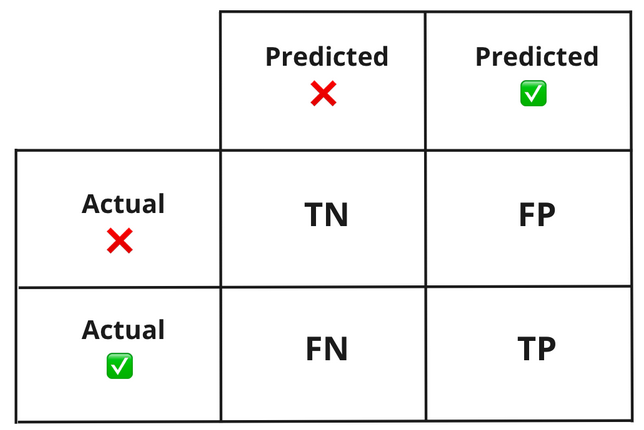


#### 4.3.1 Confusion Matrix

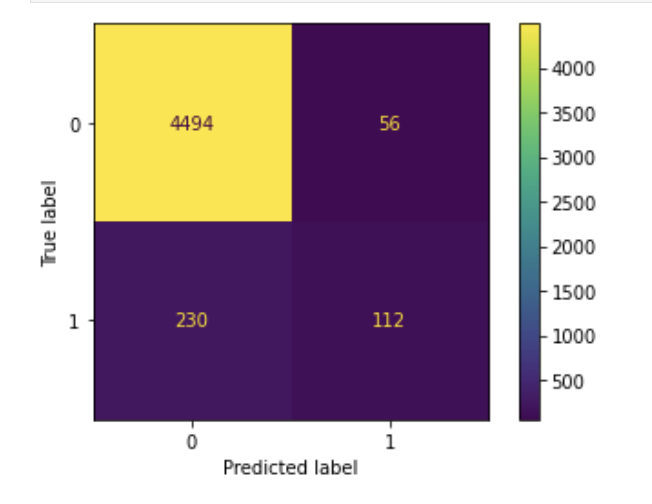

It is recommend to use from_estimator or from_predictions to create a ConfusionMatrixDisplay. All parameters are stored as attributes.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay

##### 4.3.1.1 ConfusionMatrixDisplay.from_estimator Method  (sklearn.metrics.ConfusionMatrixDisplay)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

neigh = KNeighborsClassifier(n_neighbors=11)
neigh.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(neigh, X_test, y_test)

plt.show()

##### 4.3.1.2 From Confusion_Matrix & ConfusionMatrixDisplay (sklearn.metrics.ConfusionMatrixDisplay)

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = SVC(random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()

plt.show()

##### 4.2.1.3 Crosstab (pandas.crosstab)

https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html

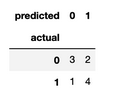

In [ ]:
y_test = [0, 1, 0, 0, 1, 0, 1, 1, 0, 1] # actual truths
preds = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1] # predictions

results_df = pd.DataFrame({"actual": y_test,
                           "predicted": preds})#Store results in dataframe

confusion_matrix = pd.crosstab(index= results_df['actual'],
                               columns = results_df['predicted'])

#### 4.3.2 Classification Metrics

1. **Accuracy** - Sum of the correct predictions divided by the sum of the overall number of predictions. Not good for predictors trained on unbalanced samples.

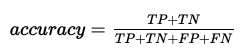

2. **Recall** - Measures the ability of the model to detect occurrences of a class.

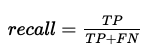

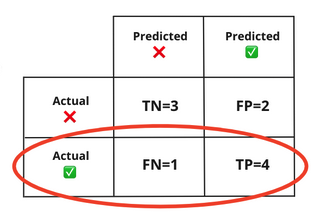

3. **Precision** - Measures the ability of a model to avoid false alarms for a class.

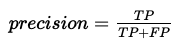

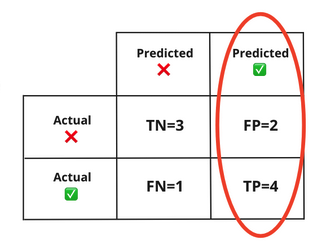

4. **F1 score** - A combination of precision and recall into a single metric.

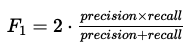


##### 4.3.2.1 From Cross Validate

In [ ]:
cv_results = cross_validate(clf, X, y, cv=5, scoring = ['accuracy', 'recall', 'precision', 'f1'])

##### 4.3.2.2 Using SKLearn Metrics (sklearn.metrics)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = [0, 1, 0, 0, 1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

print('Accuracy =', round(accuracy_score(y_true, y_pred), 2)) # Accuracy

print('Precision =', round(precision_score(y_true, y_pred), 2)) # Precision

print('Recall =', round(recall_score(y_true, y_pred), 2)) # Recall

print('F1 score =', round(f1_score(y_true, y_pred), 2)) # F1 score

Additional metrics can be found at the website below:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

#### 4.3.3 The Precision-Recall Tradeoff


    There is an inverse relationship between precision and recall
    Typically, we will trade one off against the other

You can adjust this for a given predictor by changing the threshold used in classifying predictions

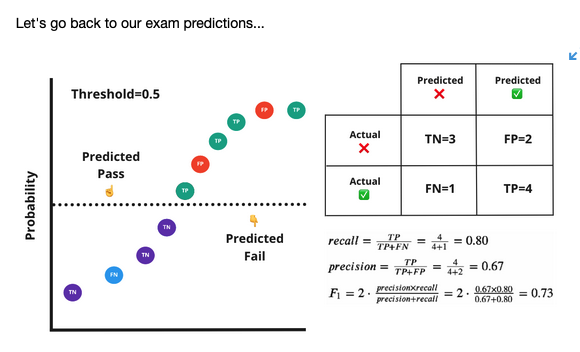

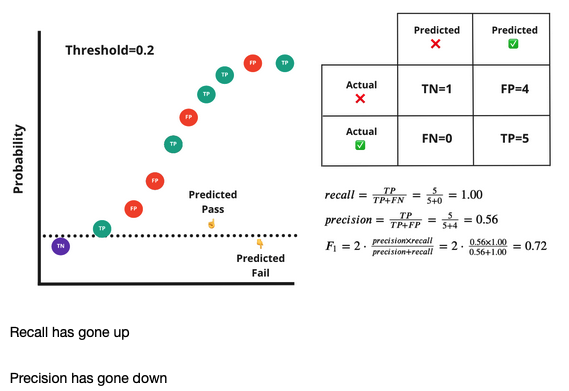

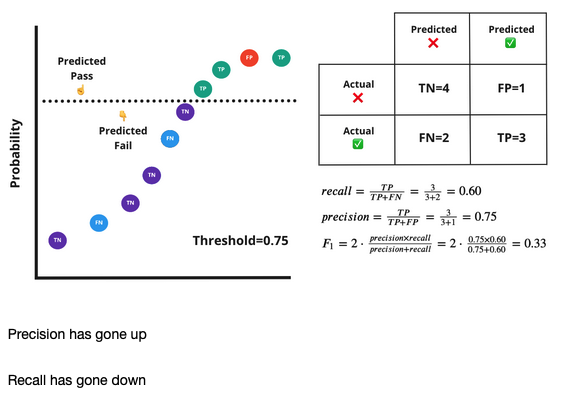

##### 4.3.3.1 Precision Recall Curve (sklearn.metrics.precision_recall_curve)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

# First you need to generate the y_pred probabilities for the classifier. The 'cross_val_predict()' 
# below is using a LogisticRegressor with two classes, so will return an array with the probabilities
# for the [0 ,1] output classes. 

# Ordinarily the model would predict y with a threshold of 0.5.

y_pred = cross_val_predict(clf, X_scaled, y, cv=10, method='predict_proba').T

print(len(y))
print(len(y_pred))

# You then feed in the observed y classes (the observed target), and the y_pred probabilities from 
# the classifier into the precision_recall_curve() function. This will generate the recall / precision
# points for thresholds between [0 1].

precision, recall, thresholds = precision_recall_curve(y, y_pred[1]) 

# This prints the resulting arrays

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'thresholds- {thresholds[:5]}')

# These are then formed into a DataFrame and the recall/precision graph plotted.

# NOTE: that the final element in the precision and recall arrays need to be removed. 
# The precision_recall_curve() puts an extra 1 at the end of them (not sure why).

scores = pd.DataFrame({'thresholds':thresholds,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})# Store in dataframe

plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

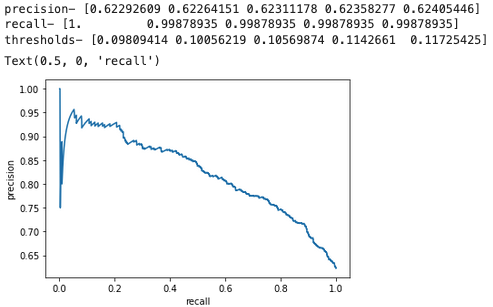

If you need to find the threshold that achieves a certain metric for your predictor, you 
would use the formula below:

In [ ]:
scores[scores['precision'] >= 0.9].thresholds.min()

You could use the code below to create a 'custom prediction wrapper' for the identified threshold:


In [ ]:
model = LogisticRegression()
model.fit(X, data['price_range_encoded'])

def custom_predict(X, custom_threshold):
    probs = model.predict_proba(X) # Get likelihood of each sample being classified as 0 or 1
    expensive_probs = probs[:, 1] # Only keep expensive likelihoods (1) 
    return (expensive_probs > custom_threshold).astype(int) # Boolean outcome converted to 0 or 1
    
    
updated_preds = custom_predict(X=X, custom_threshold=0.305539) # Update predictions 

#### 4.3.4 Classification Report (sklearn.metrics.classification_report)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(neigh, X, y, cv=5)
y_pred

cr = classification_report(y, y_pred)
print(cr)

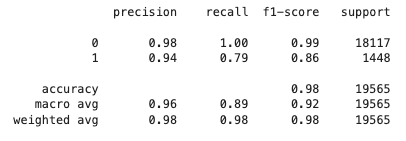

## 5 Model Tuning


### 5.1 Overfitting

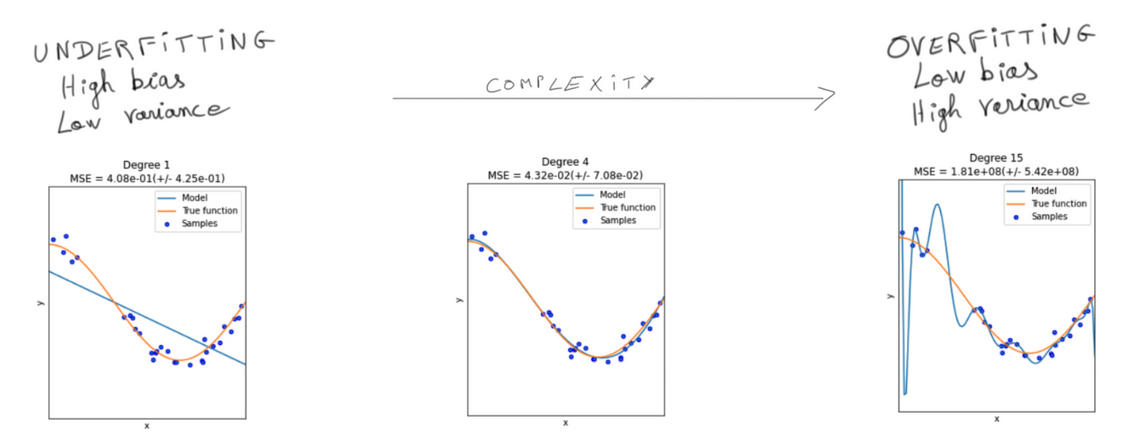

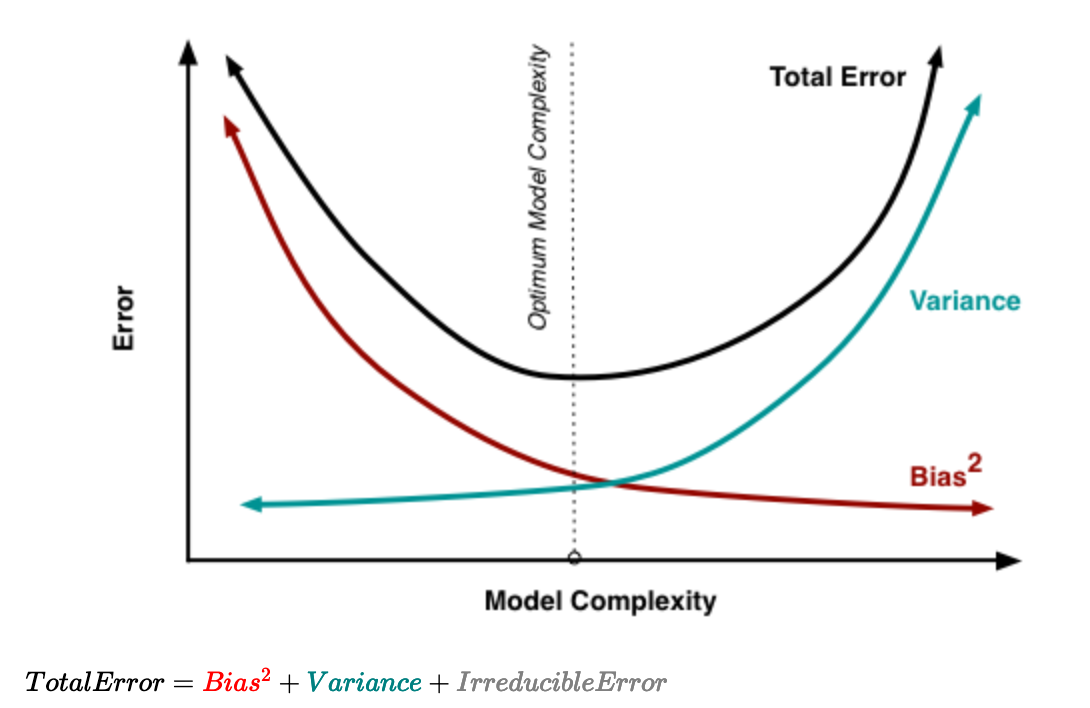

Solutions for Overfitting

        Simplify your model relatively to your data

1. Get more observations
2. Feature selection (manual or automated)
3. Dimensionality reduction (Unsupervised Learning)
4. Early stopping (Deep Learning)
5. **Regularization** of your Loss function

### 5.2 Regularization

Regularization means adding a penalty term to the Loss that increases with β

   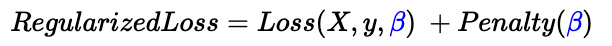
   
👉 Penalizes large values for βi
👉 Forces model to shrink certain coefficients or even select less features
👉 Prevents overfitting

The two most famous Regularization penalties are:

Ridge (L2)   
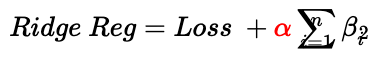   
Lasso (L1)   
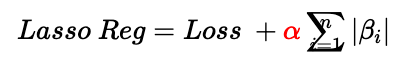   



https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [4]:
from sklearn import datasets
import pandas as pd

X,y = datasets.load_diabetes(return_X_y=True, as_frame=True)

from sklearn.linear_model import Ridge, Lasso, LinearRegression

linreg = LinearRegression().fit(X, y)
ridge = Ridge(alpha=0.2).fit(X, y)
lasso = Lasso(alpha=0.2).fit(X, y)

coefs = pd.DataFrame({
    "coef_linreg": pd.Series(linreg.coef_, index = X.columns),
    "coef_ridge": pd.Series(ridge.coef_, index = X.columns),
    "coef_lasso": pd.Series(lasso.coef_, index= X.columns)})\

coefs\
    .applymap(lambda x: int(x))\
    .style.applymap(lambda x: 'color: red' if x == 0 else 'color: black')

In [ ]:
# Can also be done by setting parameters in other models. LogisticRegression is actually penalized by default.

# penalty set to l2 uses a 'Ridge' regressor, and C to set how hard it is penalized. The lower the stronger.

# Note that not all solvers can use all regressors.

logreg_l2 = LogisticRegression(penalty='l2', C = 0.1)

logreg_l2 = LogisticRegression(solver = 'liblinear', penalty='l1', C = 0.1)

**Ridge**   
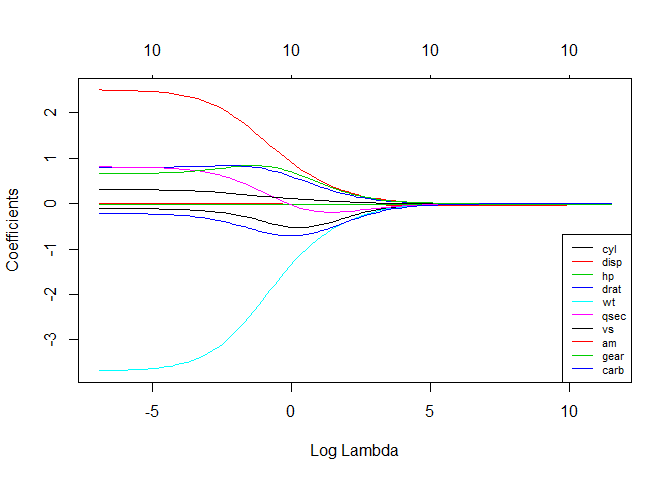

**Lasso**   
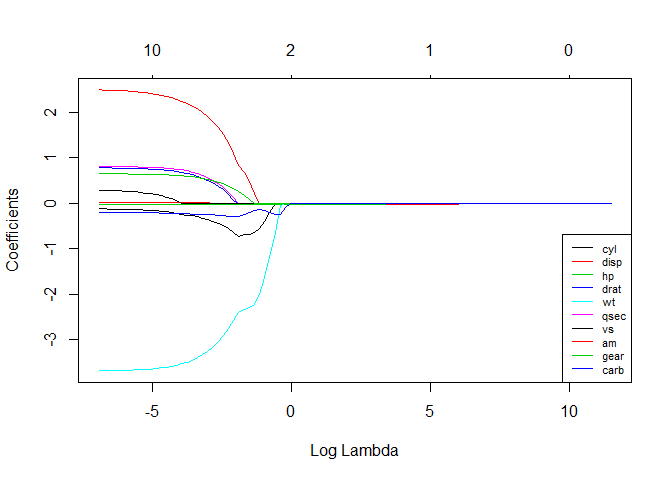

Increasing α in Ridge will only shrink parameters towards 0   
Increasing α in Lasso can shrink parameters to 0 (natural feature selector)

**ElasticNet = Lasso & Ridge weighted average**

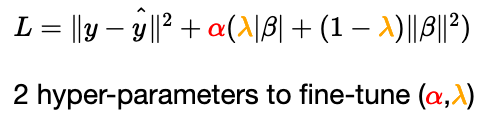

In [5]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=1, l1_ratio=0.2)

### 5.3 Model Tuning

Model Tuning

Explores different hyperparam value combinations to find those optimizing performance


1. Hold-out a validation set (never use test set for model tuning!)
2. Select which grid of values of hyper-parameters to try out
3. For each combinations of values, measure your performance on the validation set
4. Select hyperparams that produce the best performance


#### 5.3.1 Grid Search CV (sklearn.model_selection.GridSearchCV)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
from sklearn.model_selection import GridSearchCV

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

#Scale the training set if necessary

# Instanciate model
model = ElasticNet()

# Hyperparameter Grid
grid = {'alpha': [0.01, 0.1, 1], 
        'l1_ratio': [0.2, 0.5, 0.8]}

# Instanciate Grid Search
search = GridSearchCV(model,
                      grid,
                      scoring = 'r2',
                      cv = 5,
                      n_jobs=-1 # paralellize computation
                    ) 

# Fit data to Grid Search
search.fit(X_train,y_train);

# Best score
search.best_score_

# Best Params
search.best_params_

# Best estimator
search.best_estimator_

# Finally, test the best estimator on an indipendent set of observations

model_best = search.best_estimator_

model_best.fit(X_train, y_train)

model_best.score(X_test, y_test)

👎 Limitations of Grid Search:

    Computationally costly
    The optimal hyperparameter value can be missed
    Can overfit hyperparameters to the training set if too many combinations are tried out for too small a dataset

#### 5.3.2 Randomized Search CV (sklearn.model_selection.RandomizedSearchCV)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

**Example 1**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# Instanciate model
model = ElasticNet()

# Hyperparameter Grid
grid = {'l1_ratio': stats.uniform(0, 1), 'alpha': [0.001, 0.01, 0.1, 1]}

# Instanciate Grid Search
search = RandomizedSearchCV(model, grid, 
                            scoring='r2',
                            n_iter=100,  # number of draws from the grid. Start low in case comp time is long.
                            cv=5, n_jobs=-1)

# Fit data to Grid Search
search.fit(X_train, y_train)
search.best_estimator_


**Example 2**


In [ ]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

# grid = {'C': stats.uniform(10, 1000).rvs(size = 500),
#        'gamma': stats.loguniform(0.01, 0.1).rvs(size = 500),
#        'coef0': stats.uniform(0, 1).rvs(size = 20)}

grid = {'C': stats.loguniform(0.1, 10000).rvs(size = 10000),
       'gamma': stats.loguniform(0.001, 10).rvs(size = 10000),
       'coef0': stats.uniform(0, 1).rvs(size = 300), 
       'kernel': ['poly','sigmoid','rbf']}

svm = SVC(kernel='sigmoid')

svm_search = RandomizedSearchCV(svm, grid, 
                            scoring='r2',
                            n_iter=100,  # number of draws
                            cv=5, 
                            n_jobs=-1)


# Fit data to Grid Search
svm_search.fit(X,y);

print(svm_search.best_params_)

Choose hyperparameter probability distribution wisely

Can be generated with https://docs.scipy.org/doc/scipy/reference/stats.html

In [ ]:
from scipy import stats

dist = stats.norm(10, 2) # if you have a best guess (say: 10)

dist = stats.randint(1,100) # if you have no idea
dist = stats.uniform(1, 100) # same

dist = stats.loguniform(0.01, 1) # Coarse grain search

r = dist.rvs(size=10000) # Random draws
plt.hist(r);


**RandomizedSearch vs GridSearch**

👉 Randomized Search:

    Less typing, if you want to try many values
    Control for the number of combinations to try / search time
    Usefull when some hyperparams are more important than others

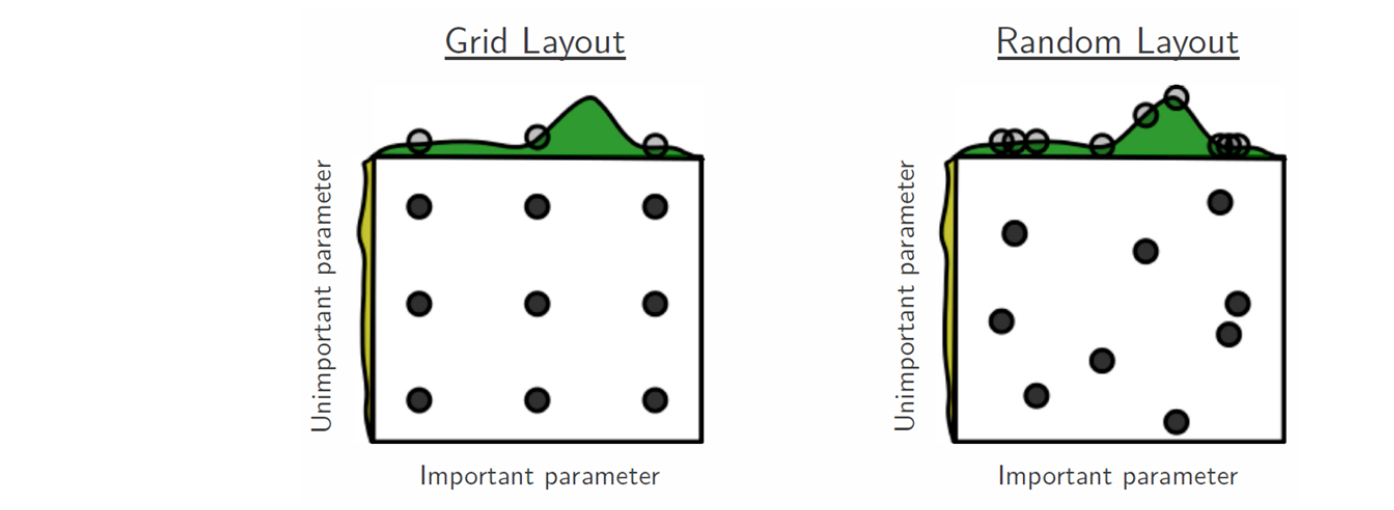


🔥 Key Summary 🔥

👉 FIT = finding best PARAMS so as to minimize LOSS

👉 FINETUNE = finding best HYPERPARAMS so as to maximize PERF METRIC

#### 5.3.3 Randomizing Folds

Setting the number of folds in a cross validation by setting the 'cv=' to an integer results in the same folds being used through out the search. 

## 6 Workflow Management

Workthrough of the LeWagon Lecture Notes On Pipelines and Workflow Management

In [183]:
df = pd.read_csv('data/insurance.csv')
df.head()

age     bmi  children  smoker     region      charges
0  19.0  27.900         0    True  southwest  16884.92400
1  18.0  33.770         1   False  southeast   1725.55230
2   NaN  33.000         3   False  southeast   4449.46200
3  33.0  22.705         0   False  northwest  21984.47061
4  32.0  28.880         0   False  northwest   3866.85520

In [184]:
X = df.drop(columns='charges')
y = df['charges']

X_train = X[:1100]
y_train = y[:1100]
X_test = X[1100:]
y_test = y[1100:]

In [185]:
# Use the module below to be able to display workflow structures

from sklearn import set_config; set_config(display='diagram')

### 6.1 Pipeline (sklearn.pipeline.Pipeline)

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

- chains together multiple steps in sequence
- e.g. Impute then Scale


In [186]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

pipe.fit(X_train[['age']])
pipe.transform(X_train[['age']])

array([[-1.45565969],
       [-1.52644066],
       [ 0.        ],
       ...,
       [-1.24331678],
       [ 0.88011225],
       [-1.03097388]])

In [82]:
pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [84]:
# access steps
pipe[1]
pipe['scaler']

StandardScaler()

### 6.2 Column Transformer

https://scikit-learn.org/stable/search.html?q=ColumnTransformer

In [99]:
from sklearn.compose import ColumnTransformer

# Impute then Scale for numerical variables: 
num_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

# Encode categorical variables
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Paralellize "num_transformer" and "One hot encoder"
preprocessor = ColumnTransformer([
    ('num_tr', num_transformer, ['age','bmi']),
    ('cat_tr', cat_transformer, ['smoker', 'region'])])

preprocessor

ColumnTransformer(transformers=[('num_tr',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'bmi']),
                                ('cat_tr',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['smoker', 'region'])])

In [105]:
X_train_transformed = preprocessor.fit_transform(X_train)

display(X_train.head(3))
display(pd.DataFrame(X_train_transformed).head(3))

age    bmi  children  smoker     region
0  19.0  27.90         0    True  southwest
1  18.0  33.77         1   False  southeast
2   NaN  33.00         3   False  southeast

0         1    2    3    4    5    6    7
0 -1.455660 -0.479092  0.0  1.0  0.0  0.0  0.0  1.0
1 -1.526441  0.492337  1.0  0.0  0.0  0.0  1.0  0.0
2  0.000000  0.364910  1.0  0.0  0.0  0.0  1.0  0.0

🤔 Where are the column names?

#### 6.2.1 get_feature_names_out()

In [97]:
# This should be fixed in Scikit-Learn 1.0.2: all transformers will have this method.
# SimpleImputer does not have a get_feature_names_out, so we need to add it manually.
SimpleImputer.get_feature_names_out = (lambda self, names=None: self.feature_names_in_)

In [102]:
# Get your feature
preprocessor.get_feature_names_out()

array(['num_tr__age', 'num_tr__bmi', 'cat_tr__smoker_False',
       'cat_tr__smoker_True', 'cat_tr__region_northeast',
       'cat_tr__region_northwest', 'cat_tr__region_southeast',
       'cat_tr__region_southwest'], dtype=object)

In [104]:
pd.DataFrame(X_train_transformed, 
             columns=preprocessor.get_feature_names_out()
            ).head()

num_tr__age  num_tr__bmi  cat_tr__smoker_False  cat_tr__smoker_True  \
0    -1.455660    -0.479092                   0.0                  1.0   
1    -1.526441     0.492337                   1.0                  0.0   
2     0.000000     0.364910                   1.0                  0.0   
3    -0.464726    -1.338815                   1.0                  0.0   
4    -0.535507    -0.316911                   1.0                  0.0   

   cat_tr__region_northeast  cat_tr__region_northwest  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       1.0   
4                       0.0                       1.0   

   cat_tr__region_southeast  cat_tr__region_southwest  
0                       0.0                       1.0  
1                       1.0                       0.0  
2                       1.0                       0.0  
3                       0.0                       0.0  
4                       0.0                       0.0

🤔 What happened to children column ? What if we want to keep it untouched?

#### 6.2.2 remainder=passthrough

In [106]:
preprocessor = ColumnTransformer([
    ('num_tr', num_transformer, ['age','bmi']),
    ('cat_tr', cat_transformer, ['region','smoker'])],
    remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_tr',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'bmi']),
                                ('cat_tr',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['region', 'smoker'])])

In [107]:
pd.DataFrame(preprocessor.fit_transform(X_train)).head(3)

0         1    2    3    4    5    6    7    8
0 -1.455660 -0.479092  0.0  0.0  0.0  1.0  0.0  1.0  0.0
1 -1.526441  0.492337  0.0  0.0  1.0  0.0  1.0  0.0  1.0
2  0.000000  0.364910  0.0  0.0  1.0  0.0  1.0  0.0  3.0

### 6.3 Custom: Function Transformer (sklearn.preprocessing.FunctionTransformer)

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

In [112]:
from sklearn.preprocessing import FunctionTransformer

# Create a transformer that compresses data to 2 digits (for instance!)
rounder = FunctionTransformer(np.round)
rounder = FunctionTransformer(lambda array: np.round(array, decimals=2))


In [113]:
# Add it at the end of our numerical transformer
num_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('rounder', rounder)])

preprocessor = ColumnTransformer([
    ('num_tr', num_transformer, ['bmi', 'age']),
    ('cat_tr', cat_transformer, ['region', 'smoker'])],
    remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_tr',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('rounder',
                                                  FunctionTransformer(func=<function <lambda> at 0x15da67ca0>))]),
                                 ['bmi', 'age']),
                                ('cat_tr',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['region', 'smoker'])])

In [114]:
pd.DataFrame(preprocessor.fit_transform(X_train)).head(2)

0     1    2    3    4    5    6    7    8
0 -0.48 -1.46  0.0  0.0  0.0  1.0  0.0  1.0  0.0
1  0.49 -1.53  0.0  0.0  1.0  0.0  1.0  0.0  1.0

❗️ FunctionTransformer only works for state-less transformations

✅ state-less transformations
X→log(X)(X1,X2)→X1+5X2

    Cannot store information on a .fit(X_train)...
    that would be applied later on a .transform(X_test)


❌ state-full transformations
X→StandardScaler(X)X→MinMaxScaler(X)

☝️ For this, we will have to code our own Class

Below is a template for a custom transfromer. You can also go to the Sklearn website to get the code for a transformer and use that as a start.

In [115]:
from sklearn.base import TransformerMixin, BaseEstimator

class MyCustomTranformer(TransformerMixin, BaseEstimator): 
    # BaseEstimator generates get_params() and set_params() methods that all pipelines require
    # TransformerMixin creates fit_transform() method from fit() and transform()
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        # Store here what needs to be stored during .fit(X_train) as instance attributes.
        # Return "self" to allow chaining .fit().transform()
        return self
    
    def transform(self, X, y=None):
        # Return result as dataframe for integration into ColumnTransformer
        return X_transformed

### 6.4 FeatureUnion (sklearn.pipeline.FeatureUnion)

In [118]:
from sklearn.pipeline import FeatureUnion

# Create a custom transformer that multiplies two columns
bmi_age_ratio_constructor = FunctionTransformer(lambda df: pd.DataFrame(df["bmi"] / df["age"]))

union = FeatureUnion([
    ('preprocess', preprocessor), # columns 0-8
    ('bmi_age_ratio', bmi_age_ratio_constructor) # new colums 9
])
union

FeatureUnion(transformer_list=[('preprocess',
                                ColumnTransformer(remainder='passthrough',
                                                  transformers=[('num_tr',
                                                                 Pipeline(steps=[('imputer',
                                                                                  SimpleImputer()),
                                                                                 ('scaler',
                                                                                  StandardScaler()),
                                                                                 ('rounder',
                                                                                  FunctionTransformer(func=<function <lambda> at 0x15da67ca0>))]),
                                                                 ['bmi',
                                                                  'age']),
                                                                ('cat_tr',
                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                 ['region',
                                                                  'smoker'])])),
                               ('bmi_age_ratio',
                                FunctionTransformer(func=<function <lambda> at 0x15da67790>))])

In [119]:
pd.DataFrame(union.fit_transform(X_train)).head(1)

0     1    2    3    4    5    6    7    8         9
0 -0.48 -1.46  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.468421

### 6.5 Summary with make_*** shortcuts

In [120]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer

In [122]:
Pipeline([
    ('my_name_for_imputer', SimpleImputer()),
    ('my_name_for_scaler', StandardScaler())
])

# Equivalent to
make_pipeline(SimpleImputer(), StandardScaler())


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [123]:
num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
cat_transformer = OneHotEncoder()

preproc_basic = make_column_transformer((num_transformer, ['age', 'bmi']),
                                       (cat_transformer, ['smoker', 'region']),
                                       remainder='passthrough')

preproc_full = make_union(preproc_basic, bmi_age_ratio_constructor)
preproc_full

FeatureUnion(transformer_list=[('columntransformer',
                                ColumnTransformer(remainder='passthrough',
                                                  transformers=[('pipeline',
                                                                 Pipeline(steps=[('simpleimputer',
                                                                                  SimpleImputer()),
                                                                                 ('standardscaler',
                                                                                  StandardScaler())]),
                                                                 ['age',
                                                                  'bmi']),
                                                                ('onehotencoder',
                                                                 OneHotEncoder(),
                                                                 ['smoker',
                                                                  'region'])])),
                               ('functiontransformer',
                                FunctionTransformer(func=<function <lambda> at 0x15da67790>))])

### 6.6 make_column_selector (select features automatically based on dtype)

In [124]:
from sklearn.compose import make_column_selector

num_col = make_column_selector(dtype_include=['float64'])
cat_col = make_column_selector(dtype_include=['object','bool'])

In [125]:
X_train.dtypes

age         float64
bmi         float64
children      int64
smoker         bool
region       object
dtype: object

In [126]:
num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
num_col = make_column_selector(dtype_include=['float64'])

cat_transformer = OneHotEncoder()
cat_col = make_column_selector(dtype_include=['object','bool'])

preproc_basic = make_column_transformer(
    (num_transformer, num_col),
    (cat_transformer, cat_col),
    remainder='passthrough')

preproc_full = make_union(preproc_basic, bmi_age_ratio_constructor)
preproc_full

FeatureUnion(transformer_list=[('columntransformer',
                                ColumnTransformer(remainder='passthrough',
                                                  transformers=[('pipeline',
                                                                 Pipeline(steps=[('simpleimputer',
                                                                                  SimpleImputer()),
                                                                                 ('standardscaler',
                                                                                  StandardScaler())]),
                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15d858d30>),
                                                                ('onehotencoder',
                                                                 OneHotEncoder(),
                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x15dbb0640>)])),
                               ('functiontransformer',
                                FunctionTransformer(func=<function <lambda> at 0x15da67790>))])

### 6.7 Including models in pipelines


- Model objects can be plugged into pipelines
- Pipelines inherit the methods of the last object in the sequence
    - Transformers: fit and transform
    - Models: fit, score, predict, etc...

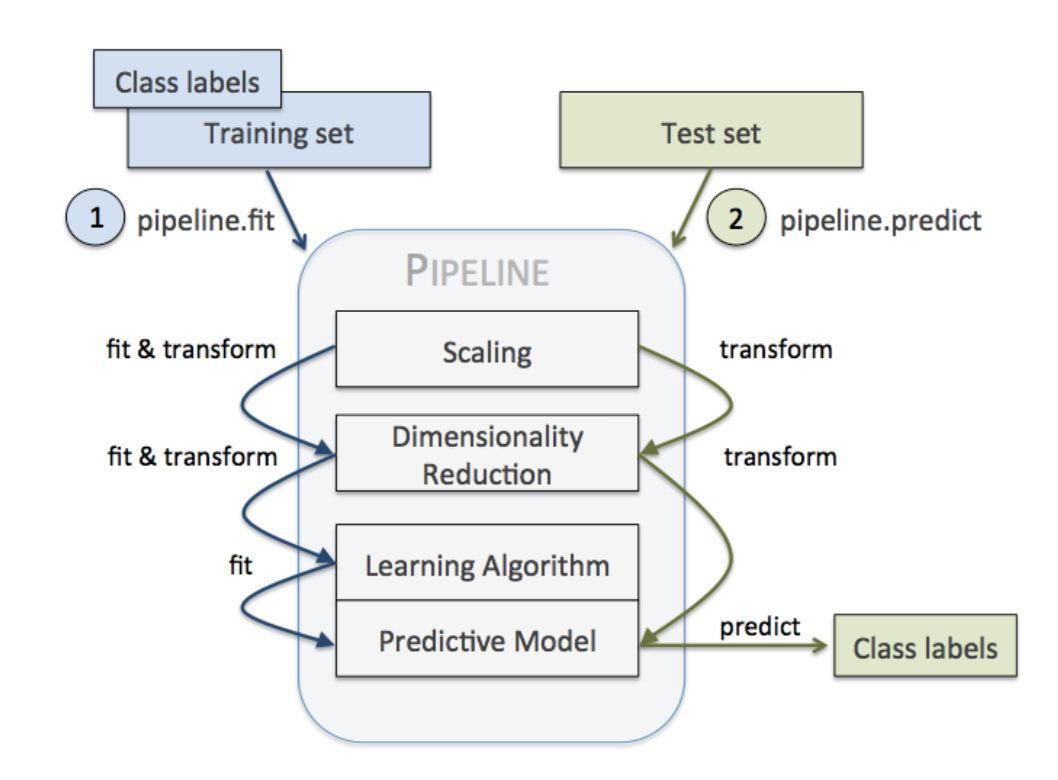


- On execution of pipeline’s fit method, the transformers' fit and transform methods will be called sequentially and the model trained
- At that point, all transformer variables are saved into the pipeline's memory and the model is trained
- On execution of pipeline’s predict method, only the transformers' transform method will be called, using the variables learnt during the original fit


#### 6.7.1 Full Pipe

In [127]:
from sklearn.linear_model import Ridge

# Preprocessor
num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
cat_transformer = OneHotEncoder()

preproc = make_column_transformer(
    (num_transformer, make_column_selector(dtype_include=['float64'])),
    (cat_transformer, make_column_selector(dtype_include=['object','bool'])),
    remainder='passthrough')

# Add Estimator
pipe = make_pipeline(preproc, Ridge())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15dbdd490>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x15dbdd130>)])),
                ('ridge', Ridge())])

In [129]:
# Train pipeline
pipe.fit(X_train,y_train)

# Make predictions
pipe.predict(X_test.iloc[0:2])

# Score model
pipe.score(X_test,y_test)

0.7472459359430912

### 6.8 Pipeline Evaluation (CV) & Optimization (GridSearch)

#### 6.8.1 Cross validate a pipeline

In [130]:
from sklearn.model_selection import cross_val_score

# Cross validate pipeline
cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()

0.7463235584349777

#### 6.8.2 Grid search a pipeline

- Check which combination of preprocessing/modelling hyperparameters work best
- It is possible to grid search hyperparameters of any component of the pipeline
- Sklearn Syntax: step_name__transformer_name__hyperparam_name
- Check available hyperparameters pipe.get_params()

In [135]:
from sklearn.model_selection import GridSearchCV

# Inspect all pipe components parameters to find the one you want to gridsearch



# Instanciate grid search
grid_search = GridSearchCV(
    pipe, 
    param_grid={
        # Access any component of the pipeline, as far back as you want
        'columntransformer__pipeline__simpleimputer__strategy': ['mean', 'median'],
        'ridge__alpha': [0.1, 0.5, 1, 5, 10]},
    cv=5,
    scoring="r2")

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'columntransformer__pipeline__simpleimputer__strategy': 'median',
 'ridge__alpha': 1}

In [136]:
pipe_tuned = grid_search.best_estimator_

### 6.8 Exporting models/pipelines

- You can export your final model/pipeline as a pickle file
- The file can be loaded back into a notebook or deployed on a server (cf. Data Engineering module)

In [137]:
import pickle

# Export pipeline as pickle file
with open("pipeline.pkl", "wb") as file:
    pickle.dump(pipe_tuned, file)

# Load pipeline from pickle file
my_pipeline = pickle.load(open("pipeline.pkl","rb"))

my_pipeline.score(X_test, y_test)

0.7472449607503218

### 6.9 AutoML

**TPOT**

Tree-based Pipeline Optimization Tool (TPOT) is an automated Machine Learning tool that optimizes machine learning pipelines.

http://epistasislab.github.io/tpot/



Installation

pip install TPOT



In [ ]:
import os
from tpot import TPOTRegressor

X_train_preproc = preproc_basic.fit_transform(X_train)
X_test_preproc = preproc_basic.transform(X_test)


In [ ]:
# instanciate TPOTClassifier
tpot = TPOTRegressor(generations=4, population_size=20, verbosity=2, scoring='r2', n_jobs=-1, cv=2)
# process autoML with TPOT
tpot.fit(X_train_preproc, y_train)

# print score
print(tpot.score(X_test_preproc, y_test))

In [ ]:
# export TPOT pipeline to a python file
tpot.export(os.path.join(os.getcwd(),'tpot_iris_pipeline.py'))

! cat 'tpot_iris_pipeline.py'

## 7. Unsupervised Learning

Unsupervised algorithms

    find patterns in X, without supervision from a target y

Reduce Dimensions

- Feature engineering / less features (save time)
- Compress (save space)

Cluster data (what makes observations close together?)

- Understand data (explo, viz...)
- Find anomaly/outliers?
- Recommendations
- Semi-supervised classifications



### 7.1 Principal Compnent Analysis (PCA)

- Squashes our high dimension dataset down into a lower dimension
- Aims to find the best linear combination of features/columns that best represent the underlying structure of the data

👉 PCA = finding the best linear combination of features...
 
Z1=a11X1+a12X2+a13X3Z2=a21X1+a22X2+a23X3Z3=a31X1+a32X2+a33X3

- Cancelling all multicolinearity
- Ranking new features Z in the most unequal way from most to least "important"

Zi are called the Principal Components (PC) 

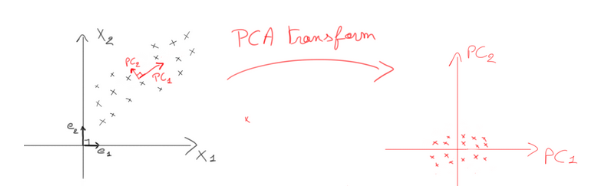

PCA returns a projection of the data

- Over some directions (Principal Components PC)
- Orthonormal to each other (0 multicolinearity)
- Ranked by decreasing "explanative power"
- (measured by the variance of our data when projected onto this PC)

In [9]:
from sklearn.datasets import load_wine

wine = load_wine()
X = wine.data
y = wine.target
wine_features = wine.feature_names

#⚠️ Data must be centered around its mean before applying PCA ⚠️
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=wine_features)
X

alcohol  malic_acid       ash  alcalinity_of_ash  magnesium  \
0    1.518613   -0.562250  0.232053          -1.169593   1.913905   
1    0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2    0.196879    0.021231  1.109334          -0.268738   0.088358   
3    1.691550   -0.346811  0.487926          -0.809251   0.930918   
4    0.295700    0.227694  1.840403           0.451946   1.281985   
..        ...         ...       ...                ...        ...   
173  0.876275    2.974543  0.305159           0.301803  -0.332922   
174  0.493343    1.412609  0.414820           1.052516   0.158572   
175  0.332758    1.744744 -0.389355           0.151661   1.422412   
176  0.209232    0.227694  0.012732           0.151661   1.422412   
177  1.395086    1.583165  1.365208           1.502943  -0.262708   

     total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
0         0.808997    1.034819             -0.659563         1.224884   
1         0.568648    0.733629             -0.820719        -0.544721   
2         0.808997    1.215533             -0.498407         2.135968   
3         2.491446    1.466525             -0.981875         1.032155   
4         0.808997    0.663351              0.226796         0.401404   
..             ...         ...                   ...              ...   
173      -0.985614   -1.424900              1.274310        -0.930179   
174      -0.793334   -1.284344              0.549108        -0.316950   
175      -1.129824   -1.344582              0.549108        -0.422075   
176      -1.033684   -1.354622              1.354888        -0.229346   
177      -0.392751   -1.274305              1.596623        -0.422075   

     color_intensity       hue  od280/od315_of_diluted_wines   proline  
0           0.251717  0.362177                      1.847920  1.013009  
1          -0.293321  0.406051                      1.113449  0.965242  
2           0.269020  0.318304                      0.788587  1.395148  
3           1.186068 -0.427544                      1.184071  2.334574  
4          -0.319276  0.362177                      0.449601 -0.037874  
..               ...       ...                           ...       ...  
173         1.142811 -1.392758                     -1.231206 -0.021952  
174         0.969783 -1.129518                     -1.485445  0.009893  
175         2.224236 -1.612125                     -1.485445  0.280575  
176         1.834923 -1.568252                     -1.400699  0.296498  
177         1.791666 -1.524378                     -1.428948 -0.595160  

[178 rows x 13 columns]

<AxesSubplot:>

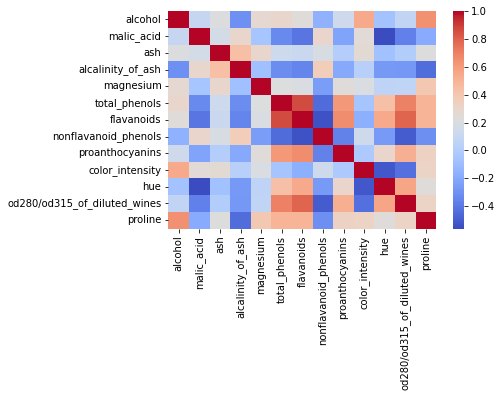

In [10]:
sns.heatmap(pd.DataFrame(X).corr(), cmap='coolwarm')

#### 7.1.1 Compute the Principal Components

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [13]:
# Access our 13 PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,
                 index=wine_features,
                 columns=[f'PC{i}' for i in range(1, 14)])
W

PC1       PC2       PC3       PC4  \
alcohol                       0.144329 -0.483652 -0.207383 -0.017856   
malic_acid                   -0.245188 -0.224931  0.089013  0.536890   
ash                          -0.002051 -0.316069  0.626224 -0.214176   
alcalinity_of_ash            -0.239320  0.010591  0.612080  0.060859   
magnesium                     0.141992 -0.299634  0.130757 -0.351797   
total_phenols                 0.394661 -0.065040  0.146179  0.198068   
flavanoids                    0.422934  0.003360  0.150682  0.152295   
nonflavanoid_phenols         -0.298533 -0.028779  0.170368 -0.203301   
proanthocyanins               0.313429 -0.039302  0.149454  0.399057   
color_intensity              -0.088617 -0.529996 -0.137306  0.065926   
hue                           0.296715  0.279235  0.085222 -0.427771   
od280/od315_of_diluted_wines  0.376167  0.164496  0.166005  0.184121   
proline                       0.286752 -0.364903 -0.126746 -0.232071   

                                   PC5       PC6       PC7       PC8  \
alcohol                      -0.265664 -0.213539 -0.056396 -0.396139   
malic_acid                    0.035214 -0.536814  0.420524 -0.065827   
ash                          -0.143025 -0.154475 -0.149171  0.170260   
alcalinity_of_ash             0.066103  0.100825 -0.286969 -0.427970   
magnesium                     0.727049 -0.038144  0.322883  0.156361   
total_phenols                -0.149318  0.084122 -0.027925  0.405934   
flavanoids                   -0.109026  0.018920 -0.060685  0.187245   
nonflavanoid_phenols         -0.500703  0.258594  0.595447  0.233285   
proanthocyanins               0.136860  0.533795  0.372139 -0.368227   
color_intensity              -0.076437  0.418644 -0.227712  0.033797   
hue                          -0.173615 -0.105983  0.232076 -0.436624   
od280/od315_of_diluted_wines -0.101161 -0.265851 -0.044764  0.078108   
proline                      -0.157869 -0.119726  0.076805 -0.120023   

                                   PC9      PC10      PC11      PC12      PC13  
alcohol                       0.508619  0.211605 -0.225917 -0.266286  0.014970  
malic_acid                   -0.075283 -0.309080  0.076486  0.121696  0.025964  
ash                          -0.307694 -0.027125 -0.498691 -0.049622 -0.141218  
alcalinity_of_ash             0.200449  0.052799  0.479314 -0.055743  0.091683  
magnesium                     0.271403  0.067870  0.071289  0.062220  0.056774  
total_phenols                 0.286035 -0.320131  0.304341 -0.303882 -0.463908  
flavanoids                    0.049578 -0.163151 -0.025694 -0.042899  0.832257  
nonflavanoid_phenols          0.195501  0.215535  0.116896  0.042352  0.114040  
proanthocyanins              -0.209145  0.134184 -0.237363 -0.095553 -0.116917  
color_intensity               0.056218 -0.290775  0.031839  0.604222 -0.011993  
hue                           0.085828 -0.522399 -0.048212  0.259214 -0.089889  
od280/od315_of_diluted_wines  0.137227  0.523706  0.046423  0.600959 -0.156718  
proline                      -0.575786  0.162116  0.539270 -0.079402  0.014447

☝️ Each PC is a linear combination of initial wine features

#### 7.1.2 Project our dataset into this new space of PCs

In [14]:
X_proj = pca.transform(X)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 14)])
X_proj

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    3.316751 -1.443463 -0.165739 -0.215631  0.693043 -0.223880  0.596427   
1    2.209465  0.333393 -2.026457 -0.291358 -0.257655 -0.927120  0.053776   
2    2.516740 -1.031151  0.982819  0.724902 -0.251033  0.549276  0.424205   
3    3.757066 -2.756372 -0.176192  0.567983 -0.311842  0.114431 -0.383337   
4    1.008908 -0.869831  2.026688 -0.409766  0.298458 -0.406520  0.444074   
..        ...       ...       ...       ...       ...       ...       ...   
173 -3.370524 -2.216289 -0.342570  1.058527 -0.574164 -1.108788  0.958416   
174 -2.601956 -1.757229  0.207581  0.349496  0.255063 -0.026465  0.146894   
175 -2.677839 -2.760899 -0.940942  0.312035  1.271355  0.273068  0.679235   
176 -2.387017 -2.297347 -0.550696 -0.688285  0.813955  1.178783  0.633975   
177 -3.208758 -2.768920  1.013914  0.596903 -0.895193  0.296092  0.005741   

          PC8       PC9      PC10      PC11      PC12      PC13  
0    0.065139  0.641443  1.020956 -0.451563  0.540810 -0.066239  
1    1.024416 -0.308847  0.159701 -0.142657  0.388238  0.003637  
2   -0.344216 -1.177834  0.113361 -0.286673  0.000584  0.021717  
3    0.643593  0.052544  0.239413  0.759584 -0.242020 -0.369484  
4    0.416700  0.326819 -0.078366 -0.525945 -0.216664 -0.079364  
..        ...       ...       ...       ...       ...       ...  
173 -0.146097 -0.022498 -0.304117  0.139228  0.170786 -0.114427  
174 -0.552427 -0.097969 -0.206061  0.258198 -0.279431 -0.187371  
175  0.047024  0.001222 -0.247997  0.512492  0.698766  0.072078  
176  0.390829  0.057448  0.491490  0.299822  0.339821 -0.021866  
177 -0.292914  0.741660 -0.117969 -0.229964 -0.188788 -0.323965  

[178 rows x 13 columns]

☝️ 178 wine bottles, each expressed as a linear combination of 13 Principal Components

✅ As expected, the PCA reduces multicolinearity to the absolute minimum (0)!

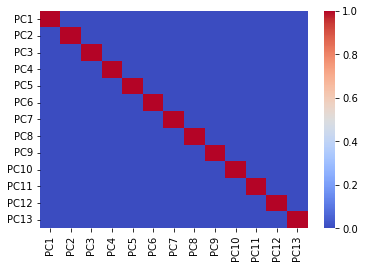

In [15]:
sns.heatmap(X_proj.corr(), cmap='coolwarm');

✅ Our wine dataset is also easier to observe in this new space

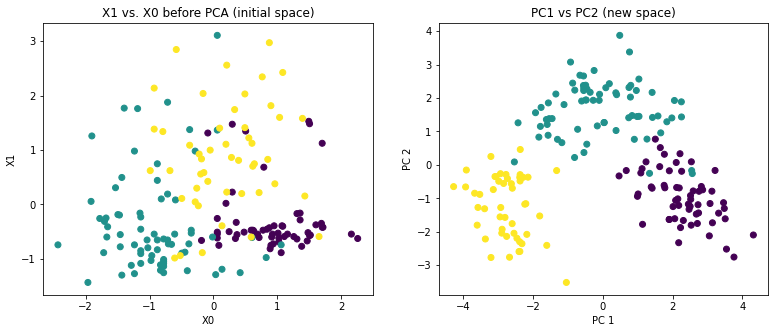

In [19]:
# 2D-slice

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title('X1 vs. X0 before PCA (initial space)'); plt.xlabel('X0'); plt.ylabel('X1')
plt.scatter(X.iloc[:,0], X.iloc[:,1], c = y)

plt.subplot(1,2,2)
plt.title('PC1 vs PC2 (new space)'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c = y);

💡 "Projecting" data onto a new space is a simple matrix multiplication

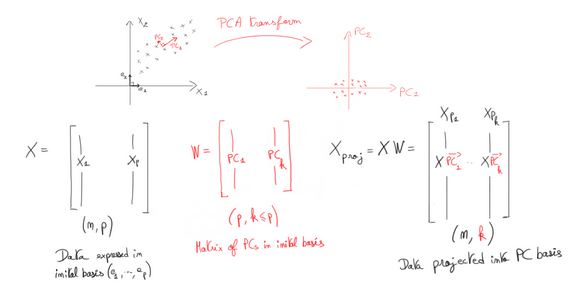

In [20]:
# Computational proof
W = pca.components_.T
print("Shape of W: ", W.shape)
print("Shape of X", X.shape)

Shape of W:  (13, 13)
Shape of X (178, 13)


In [21]:
np.allclose(
    pca.transform(X),
    np.dot(X,W)
)

True

#### 7.1.3 How are Principal Components Computed (Mathematically)?

This is the hard part

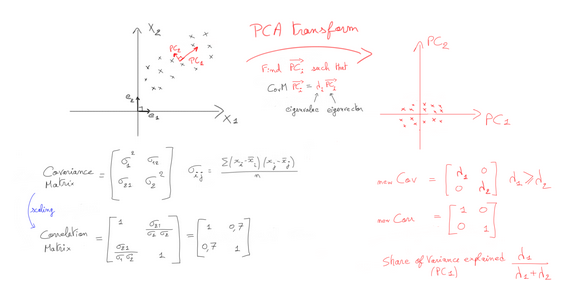

We can do it with NumPy

    np.linalg.eig(M) computes the eig_vals and eig_vecs of M
    Covariance Matrix = XTX

    of shape (p,p) (if features are centered)

❗️ eig() decomposition can take very long

ℹ️ Eigenvalues and Eigenvectors

https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors

In [22]:
# Compute PCs
eig_vals, eig_vecs = np.linalg.eig(np.dot(X.T,X))

In [23]:
# Show all 13 principal components (unranked)
W = pd.DataFrame(eig_vecs, 
                 index=wine_features,
                 columns=[f'PC{i}' for i in range(1, 14)])
W

PC1       PC2       PC3       PC4  \
alcohol                      -0.144329  0.483652 -0.207383  0.017856   
malic_acid                    0.245188  0.224931  0.089013 -0.536890   
ash                           0.002051  0.316069  0.626224  0.214176   
alcalinity_of_ash             0.239320 -0.010591  0.612080 -0.060859   
magnesium                    -0.141992  0.299634  0.130757  0.351797   
total_phenols                -0.394661  0.065040  0.146179 -0.198068   
flavanoids                   -0.422934 -0.003360  0.150682 -0.152295   
nonflavanoid_phenols          0.298533  0.028779  0.170368  0.203301   
proanthocyanins              -0.313429  0.039302  0.149454 -0.399057   
color_intensity               0.088617  0.529996 -0.137306 -0.065926   
hue                          -0.296715 -0.279235  0.085222  0.427771   
od280/od315_of_diluted_wines -0.376167 -0.164496  0.166005 -0.184121   
proline                      -0.286752  0.364903 -0.126746  0.232071   

                                   PC5       PC6       PC7       PC8  \
alcohol                      -0.265664  0.213539  0.056396 -0.014970   
malic_acid                    0.035214  0.536814 -0.420524 -0.025964   
ash                          -0.143025  0.154475  0.149171  0.141218   
alcalinity_of_ash             0.066103 -0.100825  0.286969 -0.091683   
magnesium                     0.727049  0.038144 -0.322883 -0.056774   
total_phenols                -0.149318 -0.084122  0.027925  0.463908   
flavanoids                   -0.109026 -0.018920  0.060685 -0.832257   
nonflavanoid_phenols         -0.500703 -0.258594 -0.595447 -0.114040   
proanthocyanins               0.136860 -0.533795 -0.372139  0.116917   
color_intensity              -0.076437 -0.418644  0.227712  0.011993   
hue                          -0.173615  0.105983 -0.232076  0.089889   
od280/od315_of_diluted_wines -0.101161  0.265851  0.044764  0.156718   
proline                      -0.157869  0.119726 -0.076805 -0.014447   

                                   PC9      PC10      PC11      PC12      PC13  
alcohol                       0.396139 -0.266286 -0.508619 -0.225917  0.211605  
malic_acid                    0.065827  0.121696  0.075283  0.076486 -0.309080  
ash                          -0.170260 -0.049622  0.307694 -0.498691 -0.027125  
alcalinity_of_ash             0.427970 -0.055743 -0.200449  0.479314  0.052799  
magnesium                    -0.156361  0.062220 -0.271403  0.071289  0.067870  
total_phenols                -0.405934 -0.303882 -0.286035  0.304341 -0.320131  
flavanoids                   -0.187245 -0.042899 -0.049578 -0.025694 -0.163151  
nonflavanoid_phenols         -0.233285  0.042352 -0.195501  0.116896  0.215535  
proanthocyanins               0.368227 -0.095553  0.209145 -0.237363  0.134184  
color_intensity              -0.033797  0.604222 -0.056218  0.031839 -0.290775  
hue                           0.436624  0.259214 -0.085828 -0.048212 -0.522399  
od280/od315_of_diluted_wines -0.078108  0.600959 -0.137227  0.046423  0.523706  
proline                       0.120023 -0.079402  0.575786  0.539270  0.162116

#### 7.1.4 PCs are ranked by order of importance

    PCs are ranked by share of explained variance Var(PCi)/Var(X)

❗️ Remember: information comes in the form of variation
❗️ PC with most variance is the most important one

In [25]:
# Let's compute it
X_proj.std()**2 / ((X.std()**2).sum())

PC1     0.361988
PC2     0.192075
PC3     0.111236
PC4     0.070690
PC5     0.065633
PC6     0.049358
PC7     0.042387
PC8     0.026807
PC9     0.022222
PC10    0.019300
PC11    0.017368
PC12    0.012982
PC13    0.007952
dtype: float64

☝️ scikit-learn PCA has indeed already ranked them

36% of the dataset’s variance lies along the first axis

In [26]:
# Sklearn provides it automatically
pca.explained_variance_ratio_

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

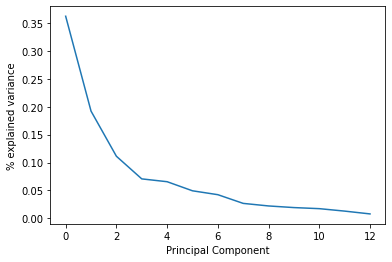

In [27]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

PCA redistributes the ratio among the new features in the most unequal way

#### 7.1.5 PCA for Dimensionality Reduction

👉 Having computed all PCs, we can now keep only the k most important ones!

 
❓ Why would we want less features? Because it means we can

    compress data
    reduce model complexity & fit time
    reduce overfitting

##### How to choose k?

It's a trade-off between compression and performance


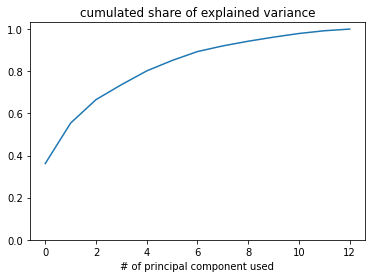

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

##### The Elbow Method

Look for the inflection point in the explained variance chart

Here, k=3 looks promising

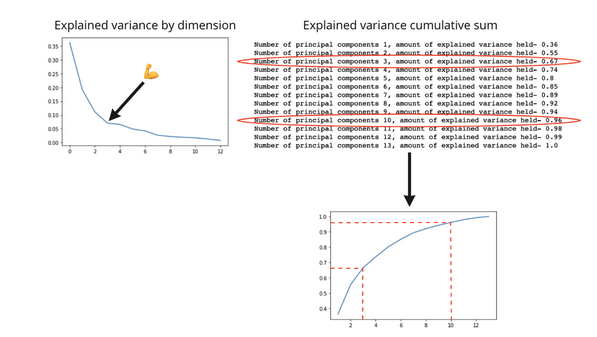

##### ✏️ Test Model Performance (with k=3 Dimensions)

In [29]:
# Fit a PCA with only 3 components
pca3 = PCA(n_components=3).fit(X)

# Project your data into 3 dimensions
X_proj3 = pd.DataFrame(pca3.fit_transform(X), columns=['PC1', 'PC2', 'PC3'])

# We have "compressed" our dataset in 3D
X_proj3

PC1       PC2       PC3
0    3.316751 -1.443463 -0.165739
1    2.209465  0.333393 -2.026457
2    2.516740 -1.031151  0.982819
3    3.757066 -2.756372 -0.176192
4    1.008908 -0.869831  2.026688
..        ...       ...       ...
173 -3.370524 -2.216289 -0.342570
174 -2.601956 -1.757229  0.207581
175 -2.677839 -2.760899 -0.940942
176 -2.387017 -2.297347 -0.550696
177 -3.208758 -2.768920  1.013914

[178 rows x 3 columns]

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

print("accuracy 3 PCs")
print(cross_val_score(LogisticRegression(), X_proj3, y, cv=5).mean())

print("\naccuracy all 13 initial features")
print(cross_val_score(LogisticRegression(), X, y, cv=5).mean())

accuracy 3 PCs
0.9609523809523809

accuracy all 13 initial features
0.9888888888888889


##### Decompress

❓ Can you perfectly reconstruct X from X_proj3?

    Not if you kept k < 13 dimensions; information has been lost
    We can approximate X by reconstructing it with inverse_transform()


In [31]:
X_reconstructed = pca3.inverse_transform(X_proj3)
X_reconstructed.shape

(178, 13)

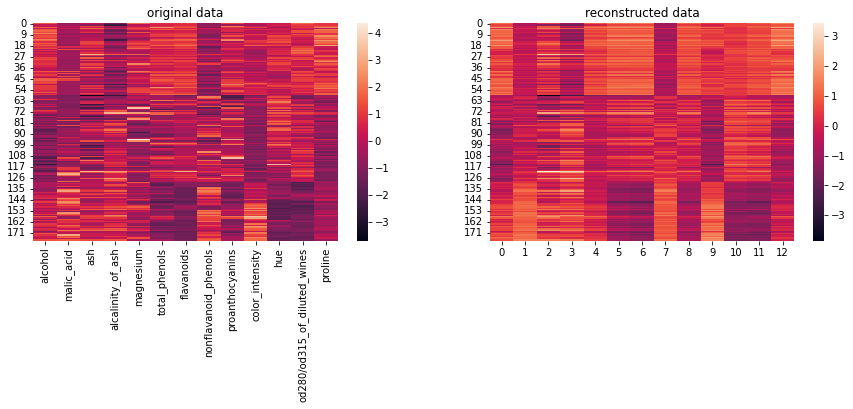

In [32]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.heatmap(X)
plt.title("original data")
plt.subplot(1,2,2)
plt.title("reconstructed data")
sns.heatmap(X_reconstructed);

#### 7.1.6 Limitations of PCA

Watch out for manifolds 👀

A manifold is an N-dimensional shape that can be bent and twisted into a higher dimensional shape 🍥

Below we can see our data distribution before and after PCA has been applied

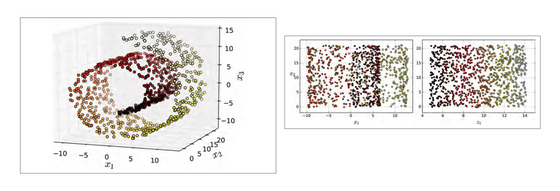

https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/



Other dimensionality reduction techniques:

    t-Distributed Stochastic Neighbor Embedding (t-SNE) — Aims to reduce dimensionality while keeping similar observations close together and dissimilar ones apart. This is a great technique for visualizing clusters of higher dimensions
    
    Kernel PCA — Captures non-linear patterns (similar principle to SVM kernels)

Summary

    We use PCA to deal with high-dimensional datasets; some pros are:
        Better visualization of the data
        Reduction of the effects of the curse of dimensionality
        Reduction of file size
    
    PCA compresses the datasets into a lower-dimensional state by projecting observations onto a new space
    
    More variation, more information, easier to distinguish between observations
    
    When we use PCA we lose data interpretability


### 7.2 Clustering

    The process of organizing data points into groups whose members are similar in some way

Find categories (classes, segments) of unlabelled data rather than just trying to reduce dimensionality

👉 Works better on data that is already clustered, geometrically speaking

👉 Use PCA for dimensionality reduction beforehand Euclidean distances work better in lower dimensions)!

#### 7.2.1 K-Means Explained

    1. Choose the number of clusters K to look for
    
    2. Initialize K centroids at random
    
    3. Compute the mean square distance between each data point and each centroid
    
    4. Assign each data point to the closest centroid (a cluster is formed)
    
    5. Compute the mean μj of each cluster, the result of which becomes your new centroid

One epoch is done, repeat from step 3!



**In practice**

    K-means is usually run a few times with different random initializations
    We can use a random mini-batch at each epoch instead of the full dataset
    The algorithm is quite fast

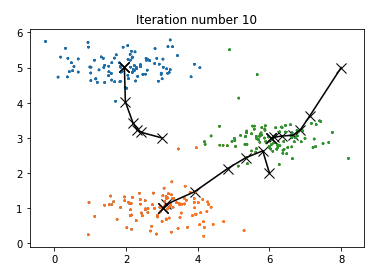

#### 7.2.2 Implementation

In Scikit-learn

https://scikit-learn.org/stable/modules/clustering.html

Use

    scikit.clustering.KMeans
    scikit.clustering.MiniBatchKMeans — same but uses batch samples instead of the whole dataset, in order to go faster

📝 Let's try to find k = 3 clusters for our wine dataset

(suppose we don't know the true labels)

 
💡 First, let's place ourselves in the Principal Component space we had already computed

Although not mandatory, applying PCA first helps to separate data more easily!


In [34]:
from sklearn.datasets import load_wine

wine = load_wine()
X = wine.data
y = wine.target
wine_features = wine.feature_names

#⚠️ Data must be centered around its mean before applying PCA ⚠️
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=wine_features)

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

X_proj = pca.transform(X)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, 14)])

X_proj

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    3.316751 -1.443463 -0.165739 -0.215631  0.693043 -0.223880  0.596427   
1    2.209465  0.333393 -2.026457 -0.291358 -0.257655 -0.927120  0.053776   
2    2.516740 -1.031151  0.982819  0.724902 -0.251033  0.549276  0.424205   
3    3.757066 -2.756372 -0.176192  0.567983 -0.311842  0.114431 -0.383337   
4    1.008908 -0.869831  2.026688 -0.409766  0.298458 -0.406520  0.444074   
..        ...       ...       ...       ...       ...       ...       ...   
173 -3.370524 -2.216289 -0.342570  1.058527 -0.574164 -1.108788  0.958416   
174 -2.601956 -1.757229  0.207581  0.349496  0.255063 -0.026465  0.146894   
175 -2.677839 -2.760899 -0.940942  0.312035  1.271355  0.273068  0.679235   
176 -2.387017 -2.297347 -0.550696 -0.688285  0.813955  1.178783  0.633975   
177 -3.208758 -2.768920  1.013914  0.596903 -0.895193  0.296092  0.005741   

          PC8       PC9      PC10      PC11      PC12      PC13  
0    0.065139  0.641443  1.020956 -0.451563  0.540810 -0.066239  
1    1.024416 -0.308847  0.159701 -0.142657  0.388238  0.003637  
2   -0.344216 -1.177834  0.113361 -0.286673  0.000584  0.021717  
3    0.643593  0.052544  0.239413  0.759584 -0.242020 -0.369484  
4    0.416700  0.326819 -0.078366 -0.525945 -0.216664 -0.079364  
..        ...       ...       ...       ...       ...       ...  
173 -0.146097 -0.022498 -0.304117  0.139228  0.170786 -0.114427  
174 -0.552427 -0.097969 -0.206061  0.258198 -0.279431 -0.187371  
175  0.047024  0.001222 -0.247997  0.512492  0.698766  0.072078  
176  0.390829  0.057448  0.491490  0.299822  0.339821 -0.021866  
177 -0.292914  0.741660 -0.117969 -0.229964 -0.188788 -0.323965  

[178 rows x 13 columns]

In [35]:
from sklearn.cluster import KMeans

# Fit K-means
km = KMeans(n_clusters=3)
km.fit(X_proj)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [36]:
# The 3 centroids' coordinates (expressed in the space of PCs)
km.cluster_centers_.shape

(3, 13)

In [38]:
# The 177 observations are classified automatically
km.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

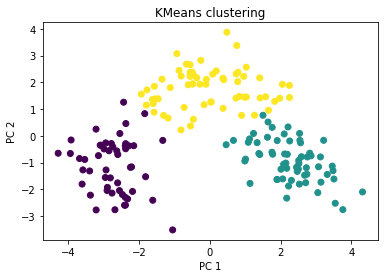

In [39]:
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2');

💡 In our case, we know the true labels; let's measure performance

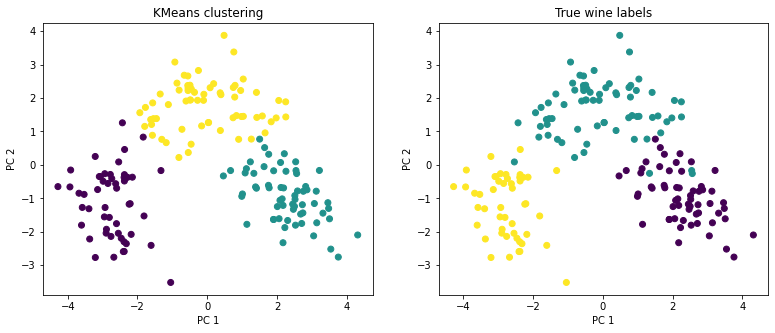

In [40]:
# Visualization
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=km.labels_)
plt.title('KMeans clustering'); plt.xlabel('PC 1'); plt.ylabel('PC 2')

plt.subplot(1,2,2)
plt.scatter(X_proj.iloc[:,0], X_proj.iloc[:,1], c=y)
plt.title('True wine labels'); plt.xlabel('PC 1'); plt.ylabel('PC 2');

In [44]:
# Accuracy
from sklearn.metrics import accuracy_score

y_pred = pd.Series(km.labels_).map({0:2, 1:0, 2:1}) # WARNING: change this manually!
accuracy_score(y_pred, y)

0.9662921348314607

##### **Predict?**

We can use the unsupervised K-means algorithm to predict (classify) a new X


In [45]:
# Build DF with column names from X_proj and some random data
new_X = pd.DataFrame(data = np.random.random((1,13)), columns = X_proj.columns)

km.predict(new_X)

array([2], dtype=int32)

#### 2.3 K-Means' Loss Function?

km.fit(X) finds parameters β

that minimize a loss

    Each βj

parameter is the centroid μj of its respective cluster Cj

    The loss function is called inertia L(μ)

    = sum of squared distance between each observation and their closest centroid
    = sum of within-cluster sum of squares (WCSS)
    = variance inertia=L(μ)=K∑j=1∑xi∈Cj(||xi−μj||2)


##### Choosing Hyperparameter K

    Choose K such that the inertia (Kmeans().inertia_) is minimized
    Use the elbow method here as well


Text(0.5, 0, 'k cluster number')

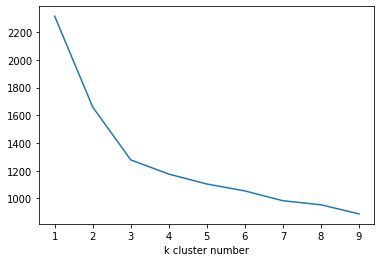

In [46]:
inertias = []
ks = range(1,10)

for k in ks:
    km_test = KMeans(n_clusters=k).fit(X)
    inertias.append(km_test.inertia_)

plt.plot(ks, inertias)
plt.xlabel('k cluster number')

What can we use it for?

👉 Document classification (finding unlabeled categories or topics)

👉 Delivery store optimization (find the optimal number of launch locations)

👉 Customer segmentation (classify different types of customer based on their behavior)

https://dzone.com/articles/10-interesting-use-cases-for-the-k-means-algorithm

#### 7.2.4 There are many other clustering approaches

https://scikit-learn.org/stable/modules/clustering.html

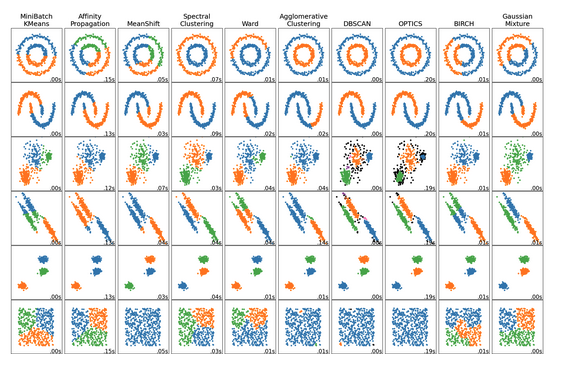

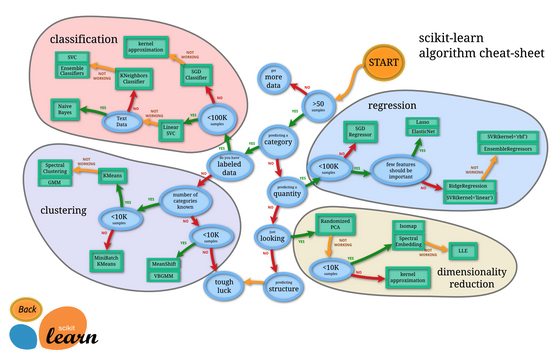

## Linear Regression (sklearn.linear_model.LinearRegression)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [3]:
from sklearn.linear_model import LinearRegression

In [8]:
df = pd.read_csv('data/houses.csv')
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 85 columns]

In [11]:
# Define X and y

X = df[['GrLivArea']]
y = df['SalePrice']

# Instanciate the model
model = LinearRegression()

# Train the model on the data
model.fit(X, y)

LinearRegression()

### Model Attributes

In [12]:
# View the model's slope (a)
model.coef_ 

array([105.00927564])

In [13]:
# View the model's intercept (b)
model.intercept_ 

22104.12101002081

### Scoring

Each Scikit-learn algorithm has a default scoring metric.

LinearRegression uses the Coefficient of determination (R2) by default.

    R2 represents the proportion of the variance of the target explained by the features.
    The score typically varies between 0 and 1
    The higher score the better the model

In [14]:
# Evaluate the model's performance
model.score(X,y)

0.48960426399689116

### Predicting

In [16]:
#  Predict on new data
model.predict([[1000]])

/Users/alexwalbridge/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([127113.39664561])

If you don't enter the predict X value using the same features as the training data, you get the annoying error above... 

In [17]:
X_predict = pd.DataFrame(
    {'GrLivArea':1000},
    index = [0]
)

model.predict(X_predict)

array([127113.39664561])

## Logistic Regression (sklearn.linear_model.LogisticRegression)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [50]:
from sklearn.linear_model import LogisticRegression

In [53]:
df = pd.read_csv('data/houses.csv')

In [68]:
X = df[['GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'OverallQual']]

# Convert the Sale Price to a binary field, which in this case is whether the price
# of the house/apartment is less than $200,000.

y = (df['SalePrice']<=200_000).astype(int)

X_predict = pd.DataFrame(
    {'GrLivArea':1000, 
     'BedroomAbvGr':4, 
     'KitchenAbvGr':1, 
     'OverallQual':7},
    index = [0]
)

# Not sure why, but it was necessary to set 
# the 'max_iter=' variable manually.

clf = LogisticRegression(max_iter=5000).fit(X, y)

# Predicted outcome? Yes or no for a logistic predictor

prediction = clf.predict(X_predict)
print(prediction)

# The probabilities that .predict_proba() returns is for all the classes in the output.

classes = clf.classes_
probability = clf.predict_proba(X_predict)

print(classes)
print(probability)
print(f'So the probability of {classes[1]} is {probability[0][1]}.')


[1]
[0 1]
[[0.07171317 0.92828683]]
So the probability of 1 is 0.9282868272510546.


## K-Nearest Neighbors

Choosing k

The optimal 𝑘 will vary from dataset to dataset.

    Lower k values, less observations to use to make a prediction, prone to overfitting
    Higher k values, signal can be diluted, prone to underfitting

### 1. KNeighbors Regressor (sklearn.neighbors.KNeighborsRegressor)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


X = df.drop('SalePrice', axis = 1)
y = df['SalePrice']

neigh = KNeighborsRegressor(n_neighbors=5)

cv_results = cross_validate(neigh, X, y, cv=5)

base_knn_score = cv_results['test_score'].mean()

**Optimizing K**

In [ ]:
# Create the DataFrame to cycle through the K values

K_test = pd.DataFrame()

K_test['K'] = [x for x in range(2,26)]
K_test['cv_results'] = 0
K_test.head()

# Cycle through the K values in each row, calculate the 
# R2 scores, and save them in the dataframe

for index, row in K_test.iterrows():
     
    neigh = KNeighborsRegressor(n_neighbors=row.K)
    
    cv_results = cross_validate(neigh, X_rescaled, y, cv=5)
    
    K_test.loc[index,'cv_results'] = cv_results['test_score'].mean()

# Find the max value for cv_score,    K_test['cv_results'].max())
# create a boolean array,             K_test['cv_results'] == K_test['cv_results'].max()
# filter the K_test dataframe,
# then get the K number with iloc[]

K_test[K_test['cv_results'] == K_test['cv_results'].max()].iloc[0,0]

**Nearest Neighbors**

You can use the below to see the closest 'neighbors' 

In [7]:
import pandas as pd

url = 'https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_spotify_data.csv'

df = pd.read_csv(url)

song = df.iloc[4295:4296,:] # Another one bites the dust - Queen

from sklearn.neighbors import KNeighborsRegressor

# Define X and y
X = df.drop(columns=['name','artists']) #Remove non numerical features
y = df['tempo']

knn_model = KNeighborsRegressor().fit(X,y) # Instanciate and train model

knn_model.kneighbors(song.drop(columns=['name','artists']),n_neighbors=10) 

(array([[0.        , 2.55269431, 2.56187197, 2.63552967, 2.7231866 ,
         2.8106185 , 3.10731868, 3.26098142, 3.53048079, 3.53614762]]),
 array([[4295, 3488, 2700, 2507, 3586, 2794, 5179, 3047, 1704, 3648]]))

Row 2 of the array returned is the index location of the songs the regressor calculates as being nearest to the song location. 

You can read more about this method at the SKLearn page.

### 2. KNeighbors Classifier (sklearn.neighbors.KNeighborsClassifier)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

neigh = KNeighborsClassifier(n_neighbors=11)
neigh.fit(X_train, y_train)

print(neigh.predict(n_patient))

### 3. NearestNeighbors - Unsupervised (sklearn.neighbors.NearestNeighbors)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

## SGD Regressor (sklearn.linear_model.SGDRegressor)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html


Loop one by one over all n observations

    Select a single, randomly selected data point
    Compute the Loss/gradient for this single point
    Update β

Once all n
observations have been viewed, repeat another epoch

By working on a single point rather than the dataset average, the SGD is less stable.

The Loss fluctuates from epoch to epoch more and does not necessarily decrease. As a result, the steps taken are less direct towards the minimum

Pros

    SGD is faster for very large datasets
    Jumps out of local minima!
    Allows to reduce RAM load (see deep learning)

Cons

    Need more epochs
    Never exactly converges (careful when to stop?)
    Maybe slower for small n

dataset with many features p

👉 Use when

    Your dataset has 6 digits or more # of observations
    
**Huber Loss** (mix of L1 and L2 losses, also called Smooth Absolute Loss)

    MAE which becomes MSE when error is small
    Adjustable for outliers
    Slope can be used as an indicator of reaching minima


In [ ]:
from sklearn.linear_model import SGDRegressor

sgdr = SGDRegressor()

sgdr_mae = SGDRegressor(loss = 'huber', epsilon=0.9)

## SGD Classifier (sklearn.linear_model.SGDClassifier)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

**loss{‘hinge’, ‘log_loss’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, ‘squared_error’, ‘huber’, ‘epsilon_insensitive’, ‘squared_epsilon_insensitive’}, default=’hinge’**

The loss function to be used.

**‘hinge’**: gives a linear SVM.   
**‘log_loss’**: gives logistic regression, a probabilistic classifier.   
**‘modified_huber’**: is another smooth loss that brings tolerance to outliers as well as probability estimates.   
**‘squared_hinge’** is like hinge but is quadratically penalized.   
**‘perceptron’** is the linear loss used by the perceptron algorithm.

The other losses, ‘squared_error’, ‘huber’, ‘epsilon_insensitive’ and ‘squared_epsilon_insensitive’ are designed for regression but can be useful in classification as well; see SGDRegressor for a description.


In [ ]:
from sklearn.linear_model import SGDClassifier

sdgc = SGDClassifier()

## Support Vector Machines


https://scikit-learn.org/stable/modules/svm.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Running through the exercise done in the bootcamp

1. Let's build our "XOR" dataset

Let's try to classify a non-linearly separable dataset like this one



To that end, we will create a 2D dataset using logical XOR gates

Try to understand how this work by playing with np.logical_xor in the cells below:



### XOR

Try to understand how this work by playing with np.logical_xor in the cells below:

In [2]:
print(np.logical_xor(True, True))
print(np.logical_xor(True, False))
print(np.logical_xor(False, False))

False
True
False


In [3]:
# Import usual libraries
import numpy as np
import matplotlib.pyplot as plt

# Make all figures tiny for readability purpose
from matplotlib import rcParams
rcParams['figure.figsize'] = (5,3)

from sklearn.svm import SVC

(500, 2)


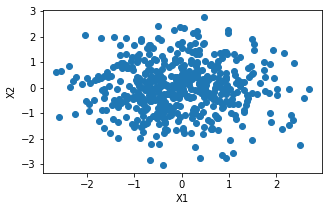

In [4]:
# Number of datapoints
n = 500
noise = 0.2

# First, build our X1,X2 randomly from gaussian distributions
np.random.seed(0)
X = np.random.randn(n, 2)
plt.scatter(X[:,0], X[:,1])
plt.xlabel("X1")
plt.ylabel("X2");

print(X.shape)
x1 = X[:, 0]
x2 = X[:, 1]

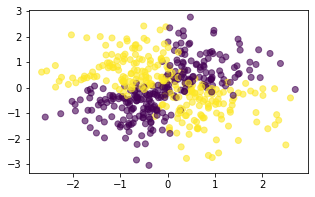

In [5]:
# Then, build our binary class y 
# where y=1 if and only if (X1 > ε xor X2 > ε)
# epsilon ε not exactly zero to simulate "noise" 

epsilon = noise * np.random.randn(n, )

y_bool = np.logical_xor(
    x1 > epsilon, 
    x2 > epsilon
)
y = np.where(y_bool, 1, 0)

# We have re-created the XOR quadrant!
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.6)

#### Polynomial Kernels

A polynomial kernel of degree 2 is as follows
𝐾(𝐚,𝐛)=(𝐚𝑇𝐛+𝑐)2

By changing the kernel, we have changed our notion of similarity: instead of measuring similarity by how close the points are in terms of dot product ("cosine similarity") for the linear kernel, we are measuring similarity based on whether points are within a circle to each other or not.

This is equivalent to creating the new quadratic features as below (Kernel Trick) 

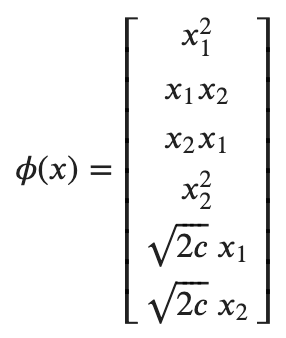


<AxesSubplot:>

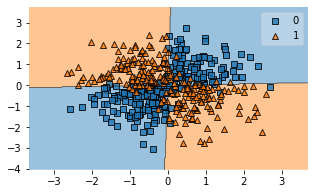

In [21]:
# Fit and plot a SVM poly of degree 2, keeping C = 100 large 
# enough so as to visualize the "maximum margin classifier"

# from utils.plots import plot_decision_regions
from mlxtend.plotting import plot_decision_regions

svc = SVC(kernel='poly', degree = 2, C=1, probability = True)

svc.fit(X,y)

plot_decision_regions(X,y,svc)

In [22]:
svc.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [24]:
# Perform classification on samples in X.
svc.predict(X[0:2])

# Compute log probabilities of possible outcomes for samples in X.
# You may need to specify probability = True when you instantiate the model.
svc.predict_log_proba(X[0:2])

# Compute probabilities of possible outcomes for samples in X. 
# You may need to specify probability = True when you instantiate the model.
svc.predict_proba(X[0:2])

# Return the mean accuracy on the given test data and labels.
svc.score(X, y)

0.89

### Moons Dataset

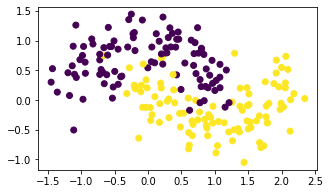

In [15]:
from sklearn.datasets import make_moons

n=200
X,y = make_moons(n_samples=n, noise=0.25, random_state=0)
plt.scatter(X[:,0], X[:,1], c=y);

Try it out visually below by changing the values of C and degree and coef0.

coef0 play the role of 𝑐
in 𝐾(𝐚,𝐛)=(𝐚𝑇𝐛+𝑐)𝑑

    When equal to 0, you only have access to the d-th degree polynomial features
    The higher it is, the more your model will consider lower degree features


In [18]:
from ipywidgets import interact # pip install ipywidgets if you haven't done it already

@interact(C=[1, 10, 1000, 10000, 100000], degree=[1,2,3,4,5,6,7,8,9], coef0=[0,0.5,1,2,5,10,100])
def svc(C, degree, coef0):
    svm = SVC(kernel='poly', C=C, coef0=coef0, degree=degree)
    svm.fit(X, y)
    plot_decision_regions(X, y, svm)

interactive(children=(Dropdown(description='C', options=(1, 10, 1000, 10000, 100000), value=1), Dropdown(descr…

☝️ A polynomial kernel can fit pretty much anything as long as the degree is high enough.

However, be aware that too high polynomial kernels will make models prone to overfitting!


#### RBF - Radial Basis Function Kernel (aka gaussian)

Here comes the RBF Kernel! Pretty much the go-to kernel for SVM (and default one in sklearn).

It proves very robust to variety of problems, and easier to fine-tune than polynomial, as it only requires gridsearching its kernel hyper-parameter gamma 𝛾, on top of C of course

𝐾(𝐚,𝐛)=exp[(−𝛾||𝐚−𝐛||2)

    The larger the euclidian distance between two points ||𝐚−𝐛||2

- The closer the kernel function is to zero. This means that two points far away are more likely to be different.

- Gamma 𝛾 reduces each instance’s range of influence on the others (myopia). Stronger 𝛾 values will make your model overfit by looking "too closely" at small-scale irregularities

- C still controls the hardness of the margin. Stronger values will make your model overfit.


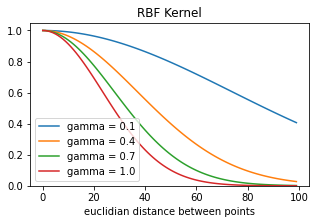

In [21]:
# Let's show below the impact of gamma "myopia" in the Kernel
for gamma in np.linspace(0.1, 1, 4):
    plt.plot(np.exp(-gamma*np.linspace(0, 3, 100)**2),
             label=f'gamma = {gamma}')
plt.ylim(0,)
plt.title('RBF Kernel')
plt.xlabel('euclidian distance between points')
plt.legend();

❓ Fit and plot decision regions of an SVM classifier with an RBF kernel

- Start with a model with very low variance (ex: gamma=0.01 and C=0.1)
- Increase gamma until you observe obvious overfitting. It should be clearly visible on the graph.

<AxesSubplot:>

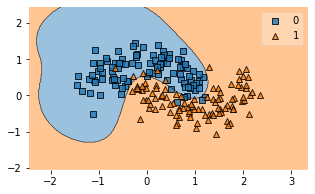

In [22]:
gamma, C = 1, 20

svc = SVC(kernel='rbf', gamma = gamma, C=C)

svc.fit(X,y)

plot_decision_regions(X,y,svc)

In [23]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(C=[0.1, 1, 10, 100, 1000, 10000], gamma = [0.001, 0.01, 0.1, 1, 10])
def svc(C=1, gamma=1):
    svm = SVC(kernel='rbf', gamma=gamma, C=C)
    svm.fit(X, y)
    plot_decision_regions(X, y, svm)

interactive(children=(Dropdown(description='C', index=1, options=(0.1, 1, 10, 100, 1000, 10000), value=1), Dro…

#### Sigmoid kernel

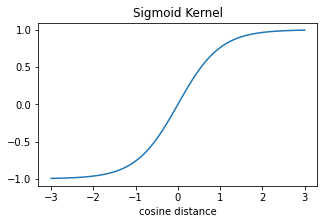

In [24]:
# The "tangent hyperbolic" function ressembles sigmoid but can take negative values
x = np.linspace(-3,3,100)
plt.plot(x, np.tanh(x))
plt.xlabel('cosine distance'); plt.title('Sigmoid Kernel');

☝️ The Sigmoid kernel compresses the "cosine similarity" used in the linear kernel into a [-𝛾
,+𝛾] interval.

❓ Try to **visually** fintune your rbf model, doing a coarse grain search for 
- `C=[0.1, 1, 10, 100, 1000, 10000]` 
- `gamma = [0.001, 0.01, 0.1, 1, 10]`  

using `@interact` decorator combined with `plot_decision_regions`

In [26]:
@interact(C=[0.1, 1, 10, 100, 1000, 10000], gamma = [0.001, 0.01, 0.1, 1, 10], coef0=0.)
def svc(C=1000, gamma=0.1, coef0=0):
    svm = SVC(kernel='sigmoid', gamma=gamma, C=C, coef0=coef0)
    svm.fit(X, y)
    plot_decision_regions(X, y, svm)

interactive(children=(Dropdown(description='C', index=4, options=(0.1, 1, 10, 100, 1000, 10000), value=1000), …

#### Grid Search the best kernel

❓ RandomizedSearchCV for the best kernel, and best kernek hyperparameters at the same time (warning: scikit-learn has issues when gridsearching polynomial kernels at the same time than other)

Use your visual intuitions above to define plausible range of values to try-out

In [30]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV

# grid = {'C': stats.uniform(10, 1000).rvs(size = 500),
#        'gamma': stats.loguniform(0.01, 0.1).rvs(size = 500),
#        'coef0': stats.uniform(0, 1).rvs(size = 20)}

grid = {'C': stats.loguniform(0.1, 10000).rvs(size = 10000),
       'gamma': stats.loguniform(0.001, 10).rvs(size = 10000),
       'coef0': stats.uniform(0, 1).rvs(size = 300), 
       'kernel': ['poly','sigmoid','rbf']}

svm = SVC(kernel='sigmoid')

svm_search = RandomizedSearchCV(svm, grid, 
                            scoring='r2',
                            n_iter=10,  # number of draws
                            cv=5, 
                            return_train_score = True,
                            n_jobs=-1)


# Fit data to Grid Search
svm_search.fit(X,y);

print(svm_search.best_params_)
print(svm_search.best_score_)

{'kernel': 'rbf', 'gamma': 0.7595956994647846, 'coef0': 0.24417547969895714, 'C': 949.5407960217686}
0.5518591436574629


In [34]:
# Returns the estimator (algorithm) with the best parameters

svm_search.best_estimator_

SVC(C=949.5407960217686, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.24417547969895714, decision_function_shape='ovr', degree=3,
    gamma=0.7595956994647846, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [32]:
svm_search.cv_results_

{'mean_fit_time': array([3.56979370e-03, 6.36687279e-03, 5.22413254e-03, 4.19621468e-03,
        5.41157722e-03, 7.30155897e+00, 2.90656090e-03, 2.04309940e-02,
        4.28223610e-03, 5.16982079e-03]),
 'std_fit_time': array([6.44564078e-04, 2.62210000e-04, 8.88429508e-04, 2.35321693e-04,
        1.02343785e-04, 4.10672758e+00, 3.28527549e-04, 6.18492553e-03,
        4.47486814e-04, 5.02972626e-04]),
 'mean_score_time': array([0.00090685, 0.00161371, 0.00104146, 0.00124426, 0.00155339,
        0.00048547, 0.00077405, 0.00065699, 0.00072637, 0.00124631]),
 'std_score_time': array([1.72985165e-04, 1.93151813e-04, 4.29427256e-04, 1.14349130e-04,
        1.94798257e-04, 6.74650269e-05, 4.02057714e-05, 7.08433999e-05,
        1.44605143e-05, 7.76094920e-05]),
 'param_kernel': masked_array(data=['poly', 'sigmoid', 'poly', 'rbf', 'sigmoid', 'poly',
                    'poly', 'rbf', 'poly', 'sigmoid'],
              mask=[False, False, False, False, False, False, False, False,
              

In [41]:
g = svm_search.best_params_['gamma']
coe = svm_search.best_params_['coef0']
C = svm_search.best_params_['C']
k = svm_search.best_params_['kernel']

In [42]:
from sklearn.model_selection import cross_validate

svm = SVC(kernel=k,gamma = g, coef0 = coe, C = C)

cv_results = cross_validate(svm, X, y, cv=5)
sigmoid_svm_cv_accuracy = cv_results['test_score'].mean()

sigmoid_svm_cv_accuracy

0.9399999999999998

In [43]:
svm = SVC(kernel=k,gamma = g, coef0 = coe, C = C)
svm.fit(X,y)

SVC(C=0.44251357487435117, coef0=0.823484449586257, gamma=4.421347535712987)

After a few days, it has received and predicted new data points never having seen them before (our "test set")

In [45]:
# Generate a half-moon test_set of size n_test
n_test = 100
X_test, y_test = make_moons(n_samples=n, noise=0.2, random_state=1)

X_full = np.vstack((X, X_test))
y_full = np.append(y, values = y_test)
test_idx = np.arange(n,n+n_test)

❓ Visualize its performance by doing plot_decision_regions including test_idx as optional argument.
Count how many misclassified test samples you get!


<AxesSubplot:>

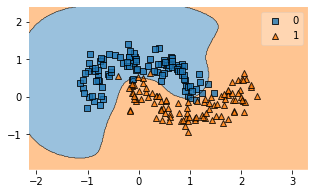

In [46]:
plot_decision_regions(X_test,y_test,svm)

#### kNN vs. SVM ?

In [47]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=30)

cv_results = cross_validate(neigh, X, y, cv=5)
knn_score = cv_results['test_score'].mean()

neigh.fit(X, y)
neigh.score(X_test,y_test)

0.965

<AxesSubplot:>

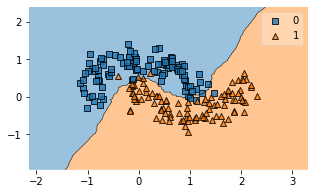

In [48]:
plot_decision_regions(X_test,y_test,neigh)

## Ensemble Methods

Going to work through the lecture notes and add material from challenges

In [199]:
from sklearn.datasets import load_iris

iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
data.drop(columns=['sepal length (cm)', 'sepal width (cm)'], inplace=True)

X = data.drop(columns=['target']).values
y = data.target.values.astype(int)

data.head()

petal length (cm)  petal width (cm)  target
0                1.4               0.2     0.0
1                1.4               0.2     0.0
2                1.3               0.2     0.0
3                1.5               0.2     0.0
4                1.4               0.2     0.0

**Ensemble Methods Summary**

Ensemble learning combines several base algorithms (eg. Trees)
Ensemble methods can be broken down into two categories:

Parallel Learners: models trained in parallel and predictions aggregated

    RandomForestRegressors
    BaggingRegressors

Sequential Learners: models trained sequentially so at to learn from predecessors' mistakes

    AdaBoostRegressor
    GradientBoostRegressor
    XGBoostRegressor


### 1. Decision Trees

#### 1.1 DecisionTreeClassifier (sklearn.tree.DecisionTreeClassifier)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [154]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=2)
tree_clf.fit(X,y)

DecisionTreeClassifier(max_depth=2, random_state=2)

In [155]:
# Let's predict the class of a new flower
print(tree_clf.predict([[4,1]]))

[1]


In [156]:
# Predict proba
print(tree_clf.predict_proba([[4,1]]))

[[0.         0.90740741 0.09259259]]


<AxesSubplot:>

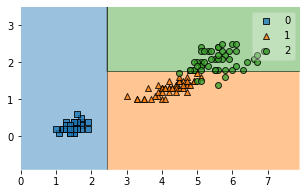

In [157]:
# hand made function to plot all predictions
plot_decision_regions(X, y, tree_clf)

#### 1.2 DecisionTreeRegressor (sklearn.tree.DecisionTreeRegressor)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html


⚠️ Controlling overfitting

- Decision trees must be tuned!!
- Default parameters will almost certainly overfit
- Control split
- Control tree depth

min_samples_split

    Specify the minimum number of samples required to split an internal node
    In the example, set to 7


min_samples_leaf

    The minimum number of samples required to be at a leaf node.
    The smaller the more it overfits


max_depth

    The maximum depth of the tree
    The larger the more it overfits

In [160]:
from sklearn.tree import DecisionTreeRegressor

#### 1.3 Variance illustrated

Below are illustrative examples of how important fitting a descision tree can be, and how much variation there can in scores across different test sets.

##### 1.3.1 Regression

In [188]:
data = pd.read_csv('data/flats.csv')
data.head(3)

price  bedrooms  surface  floors
0  274.0         3     1830     2.0
1  500.0         4     2120     1.0
2  320.0         3     1260     1.0

In [189]:
X = data[['bedrooms','surface','floors']]
y = data['price']

<BarContainer object of 5 artists>

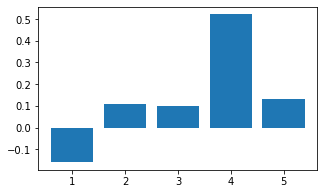

In [190]:
tree = DecisionTreeRegressor()

cv_results = cross_validate(tree, X, y, scoring = "r2", cv=5)

# custom method
plt.bar([1,2,3,4,5], cv_results['test_score'])

##### 1.3.2 Classification

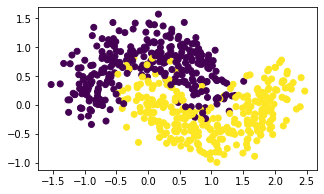

In [172]:
from sklearn.datasets import make_moons
n=600
X_moon,y_moon = make_moons(n_samples=n, noise=0.25, random_state=0)
plt.scatter(X_moon[:,0], X_moon[:,1], c=y_moon)

In [192]:
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact

In [193]:
@interact(max_depth=[1,2,3,4,5,6,7,8,9,10])

def plot_classifier(max_depth):
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_moon, y_moon)
    plot_decision_regions(X_moon, y_moon, clf)

# plot_classifier(max_depth=10)

interactive(children=(Dropdown(description='max_depth', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=1), Out…

### 2. Bagging (RandomForrest & BoostedRegressor/Classifier) 

Bootstrap aggregating, also known as Bagging, is the aggregation of multiple versions of a model.

- It is a parallel ensemble method
- The aim of bagging is to reduce variance
- Each version of the model is called a weak learner
- Weak learners are trained on boostrapped samples of the dataset

Bootstrapping

- Generating "bootstrapped" samples from the given dataset
- The samples are created by randomly drawing the data points with replacement.
- Features can also be randomly filtered to increase bagging diversity


**Random Forests = Bagged Trees**

Random Forests are a Bagged ensemble of Decision trees.   
Prediction are averaged (for regression) or voted (classification)


Pros and cons of Bagging

👍 Advantages:

    Reduces variance/overfitting
    Can be applied to any model

👎 Disadvantages

    Complex structure
    High training time
    Disregards the performance of individual sub-models



#### 2.1 RandomForestRegressor (sklearn.ensemble.RandomForestRegressor)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

<BarContainer object of 5 artists>

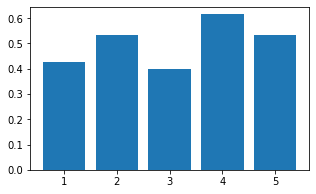

In [179]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100)

cv_results = cross_validate(forest, X, y, scoring = "r2", cv=5)

plt.bar([1,2,3,4,5], cv_results['test_score'])

#### 2.2. RandomForestClassifier (sklearn.ensemble.RandomForestClassifier)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [194]:
from sklearn.ensemble import RandomForestClassifier

@interact(max_depth=5)

def plot_classifier(max_depth):
    cls = RandomForestClassifier(max_depth=max_depth)
    cls.fit(X_moon, y_moon)
    plot_decision_regions(X_moon, y_moon, cls)

interactive(children=(IntSlider(value=5, description='max_depth', max=15, min=-5), Output()), _dom_classes=('w…

#### 2.3 BaggingClassifier (sklearn.ensemble.BaggingClassifier)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

A baggind classifier uses many bagged versions of a weal_learner algorithm

<AxesSubplot:>

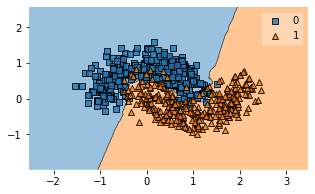

In [196]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

weak_learner = KNeighborsClassifier(n_neighbors=3)
bagged_model = BaggingClassifier(weak_learner, n_estimators=40)

bagged_model.fit(X_moon, y_moon)
plot_decision_regions(X_moon, y_moon, bagged_model)

#### 2.4 BaggingRegressor (sklearn.ensemble.BaggingRegressor)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

#### 2.5 Bagging Regressor/Classifier Stuff

**Out-of-Bag samples**

Sample not "drawn" by the bagging can be used to give a pseudo "test" score


In [ ]:
bagged_model = BaggingRegressor(linear_model, 
                                n_estimators=50,
                                oob_score=True)

bagged_model.fit(X,y).oob_score_

In [ ]:
#💡 Notice

RandomForestClassifier(n_estimators=100)
BaggingClassifier(DecisionTreeClassifier(), n_estimators=100)  # similar (but slightly less optimized)

BaggingRegressor(RandomForestClassifier(), n_estimators=100)  # stupid! 10,000 trees to train!


### 3. Boosting

Boosting is a sequential ensemble method made up of weak learners that learn from their predecessor's mistakes.

- It is a sequential ensemble method
- The aim of boosting is to reduce bias
- Focuses on the observations that are harder to predict
- The best weak learners are given more weight in the final vote

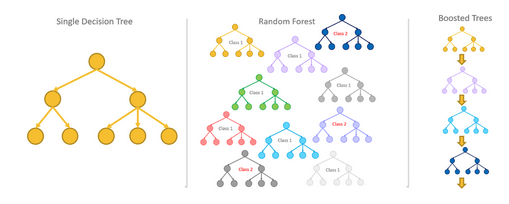

#### 3.1 AdaBoost (Adaptative Boosting)

One implementation of boosting that works particularly well with trees.

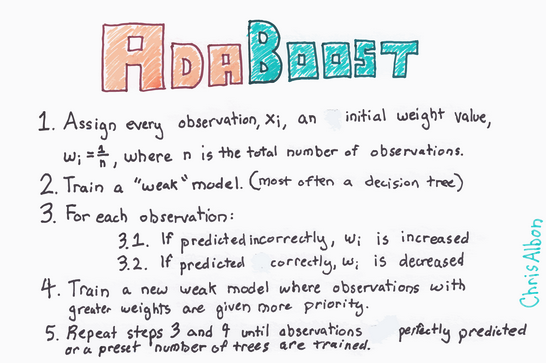

##### 3.1.1 AdaBoostRegressor (sklearn.ensemble.AdaBoostRegressor)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

<BarContainer object of 5 artists>

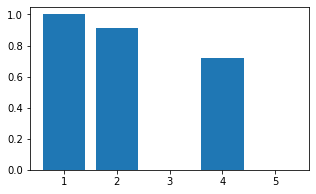

In [201]:
from sklearn.ensemble import AdaBoostRegressor

adaboost = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=3),
    n_estimators=50)

cv_results = cross_validate(adaboost, X, y, scoring = "r2", cv=5)

plt.bar([1,2,3,4,5], cv_results['test_score'])

##### 3.1.2 AdaBoostClassifier (sklearn.ensemble.AdaBoostClassifier)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [206]:
from sklearn.ensemble import AdaBoostClassifier

@interact(n_estimators=[10, 30, 50,100], max_depth=3)

def plot_classifier(n_estimators, max_depth):
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                               n_estimators=n_estimators)    
    model.fit(X_moon, y_moon)
    plot_decision_regions(X_moon, y_moon, model)
    


interactive(children=(Dropdown(description='n_estimators', options=(10, 30, 50, 100), value=10), IntSlider(val…

### 4. Gradient Boosting

- Only implemented for trees
- Generally more performant than AdaBoost

Instead of updating the weights of observations misclassified...

1. Recursively fit each weak-learner dtree i so as to predict residuals of the previous one
2. Then adds all the predictions of each weak learners

D(x)=dtree 1(x)+dtree 2(x)+...+dtree n(x)

For classification, ~ similar principle but in the logit space (if loss chosen is log-loss)

📚 scikit-learn https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting   
📚 Brilliantly Wrong visual blog post https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html   


Pros and cons of boosting

👍 Advantages:

    Strong sub-models have more influence in final decision
    Reduce bias

👎 Disadvantages:

    Computationally expensive (sequential)
    Easily overfit
    Sensitive to outliers (too much time spent trying to correctly predict them)


#### 4.1 GradientBoostingRegressor (sklearn.ensemble.GradientBoostingRegressor)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1,
    max_depth=3
)

#### 4.2 GradientBoostedClassifier (sklearn.ensemble.GradientBoostingClassifier)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

#### 4.3 XGBoost

https://xgboost.readthedocs.io/en/latest/


- Extreme Gradient Tree Boosting
- Dedicated library, optimized for this task
- bNice features inspired from Deep Learning


In [ ]:
from xgboost import XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)

xgb_reg.fit(X_train, y_train,
    # evaluate loss at each iteration
    eval_set=[(X_train, y_train), (X_val, y_val)],  
    # stop iterating when eval loss increases 5 times in a row
    early_stopping_rounds=5
)

y_pred = xgb_reg.predict(X_val)

Or integrate it into scikit-learn as Pipeline 🎉

In [ ]:
from sklearn.pipeline import make_pipeline

pipe_xgb = make_pipeline(xgb_reg)
cv_results = cross_validate(pipe_xgb,X,y,cv=10,scoring='r2')

### 5. Stacking

Training different estimators and aggregating their predictions.

- Different estimators (KNN, LogReg...) capture different structures of data
- Combining sometimes enhances the predictive power
- The results are aggregated by voting (classification) or averaging (regression)


#### 5.1 Simple Aggregation

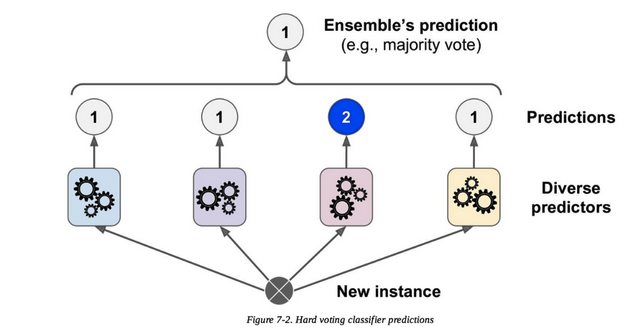

##### 5.1.1 VotingClassifier (sklearn.ensemble.VotingClassifier)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

<AxesSubplot:>

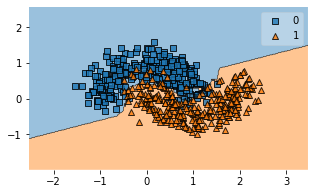

In [208]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

forest = RandomForestClassifier()
logreg = LogisticRegression()

ensemble = VotingClassifier(
    estimators = [("rf", forest),("lr", logreg)],
    voting = 'soft', # to use predict_proba of each classifier before voting
    weights = [1,1] # to equally weight forest and logreg in the vote
)
ensemble.fit(X_moon, y_moon)
plot_decision_regions(X_moon, y_moon, ensemble)

##### 5.1.2 VotingRegressor (sklearn.ensemble.VotingRegressor)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html

#### 5.2 Multi-Layer Stacking

Train a final estimator on the predictions of the previous ones

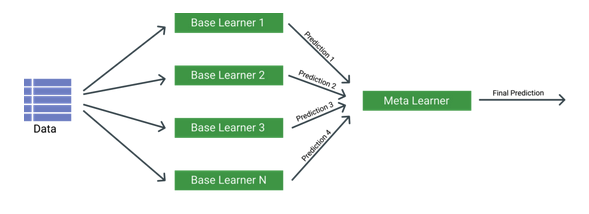

<AxesSubplot:>

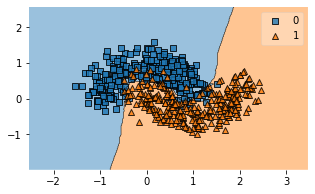

In [211]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

ensemble = StackingClassifier(
    estimators = [("rf", RandomForestClassifier()),
                  ("knn", KNeighborsClassifier(n_neighbors=10))],
    final_estimator = LogisticRegression())

ensemble.fit(X_moon, y_moon)
plot_decision_regions(X_moon, y_moon, ensemble)

## Cross-validation (sklearn.model_selection.cross_validate)

The dataset is split into K number of folds.
For each split, a sub model is trained and scored.
The average score of all sub models is the cross-validated score of the model

In [27]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

LinearRegression uses the Coefficient of determination (R2) by default.

Below is a list of all the other metrics that can be specified:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [46]:
model = LinearRegression()

cv_results = cross_validate(model, X, y, cv=5)
cv_score = cv_results['test_score'].mean()

print(cv_results)
print(f'\nCV Score is :{cv_score}')

{'fit_time': array([0.00292015, 0.00239277, 0.00282907, 0.00207019, 0.00233412]), 'score_time': array([0.00166512, 0.00165296, 0.00145984, 0.00220108, 0.00152516]), 'test_score': array([0.55810657, 0.52593307, 0.50430916, 0.3911751 , 0.45203221])}

CV Score is :0.4863112208425962


**Cross Validate with other regression metrics specified**

In [ ]:
cv_results_K = cross_validate(neigh, X_rescaled, y, cv=5, scoring = ['neg_mean_absolute_error', 'r2'])

**Cross Validate with a classifier, including classification metrics**

In [ ]:
X = df.drop('target',axis = 1).copy()
y = df.target.copy()

clf = LogisticRegression(max_iter=5000).fit(X, y)

cv_results = cross_validate(clf, X, y, cv=5, scoring = ['accuracy', 'recall', 'precision', 'f1'])

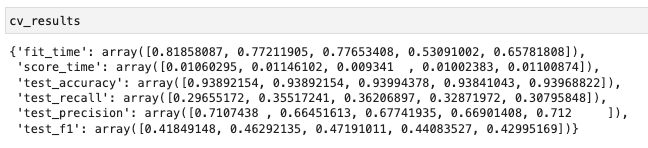

## Train / Test Split (sklearn.model_selection.train_test_split)

In [28]:
from sklearn.model_selection import train_test_split

Used to split data into training and testing sets. This is done randomly, so will be different each time you run it. 

In [29]:
# split the data into train and test
train_data, test_data = train_test_split(df, test_size=0.3)

# Ready X's and y's
X_train = train_data[['GrLivArea']]
y_train = train_data['SalePrice']

X_test = test_data[['GrLivArea']]
y_test = test_data['SalePrice']

You could also directly pass X and y to train_test_split.

In [39]:
# Ready X and y
X = df[['GrLivArea']]
y = df['SalePrice']

# Split into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


Fit the model with the training data above, and then test against the test data

In [38]:
# Instantiate the model
model = LinearRegression()

# Train the model on the Training data
model.fit(X_train, y_train)

# Score the model on the Test data
model.score(X_test,y_test)


0.4393478032401271

## Learning Curves (sklearn.model_selection.learning_curve)

In [48]:
import numpy as np
from sklearn.model_selection import learning_curve

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

Learning curves are used to diagnose three aspects of model behaviour on the dataset:

    Underfitting
    Overfitting
    Whether the model has sufficient data to learn the patterns of the dataset


**High bias / Underfitting**

Low scores in both training and test sets.

If the model cannot determine a relationship in the training set, we cannot expect the model to score highly in the test set.

Training and testing scores converge and plateau at a low score. No matter how much data is used for training, the model cannot determine a meaningful relationship.

**High variance / Overfitting**

The model has paid too much attention to both signal and noise, this leads to high training scores.

Reliance on noise does not generalize well on unseen data, resulting in low test scores.

Concept

Increasing the size of the training set can affect the training and validation scores.

### Learning Curves with Sklearn

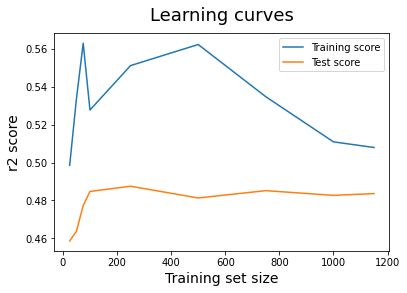

In [49]:
train_sizes = [25,50,75,100,250,500,750,1000,1150]
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=LinearRegression(), X=X, y=y, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

## Custom Performance Metric

You are able to create a custom performance metric for scoring and calibration, should you want to use one that is not part of the standard scoring metrics on Sklearn.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

In [212]:
from sklearn.metrics import make_scorer

In [ ]:
def sqrt_mean_squared_ln_error(y_true, y_pred):
    return np.sqrt(np.average((np.log(1+y_true) - np.log(1+y_pred)) ** 2))
   
def sqrt_mean_squared_ln_error_neg(y_true, y_pred):
    return -np.sqrt(np.average((np.log(1+y_true) - np.log(1+y_pred)) ** 2))     

rmsle = make_scorer(sqrt_mean_squared_ln_error)
rmsle_neg = make_scorer(sqrt_mean_squared_ln_error_neg)

# Code Examples

## Model Tuning